<a href="https://colab.research.google.com/github/carolinaribeiromagalhaes-creator/ArtigoFinalPPE/blob/main/ArtigoFinalPPE_CarolRibeiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importação dos dados e primeiras análises

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, probplot, expon, lognorm
from sklearn.mixture import GaussianMixture
from scipy.stats import jarque_bera, ttest_1samp, kstest, norm, anderson
from statsmodels.stats.diagnostic import lilliefors
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm, kurtosis, skew, jarque_bera, kstest, lognorm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

# Carregar o arquivo CSV
file_path = 'all_stocks_5yr.csv'
df = pd.read_csv(file_path)

#plotar dataset

df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [ ]:
# Filtrar dados da AAL (as empresas estão em ordem alfabética, esta sendo, portanto, a primeira) -> é possível automatizar isso para termos os dados de cada uma das empresas
df_aal = df[df['Name'] == 'AAL'].copy()
df_aal['date'] = pd.to_datetime(df_aal['date'])
df_aal.sort_values('date', inplace=True)

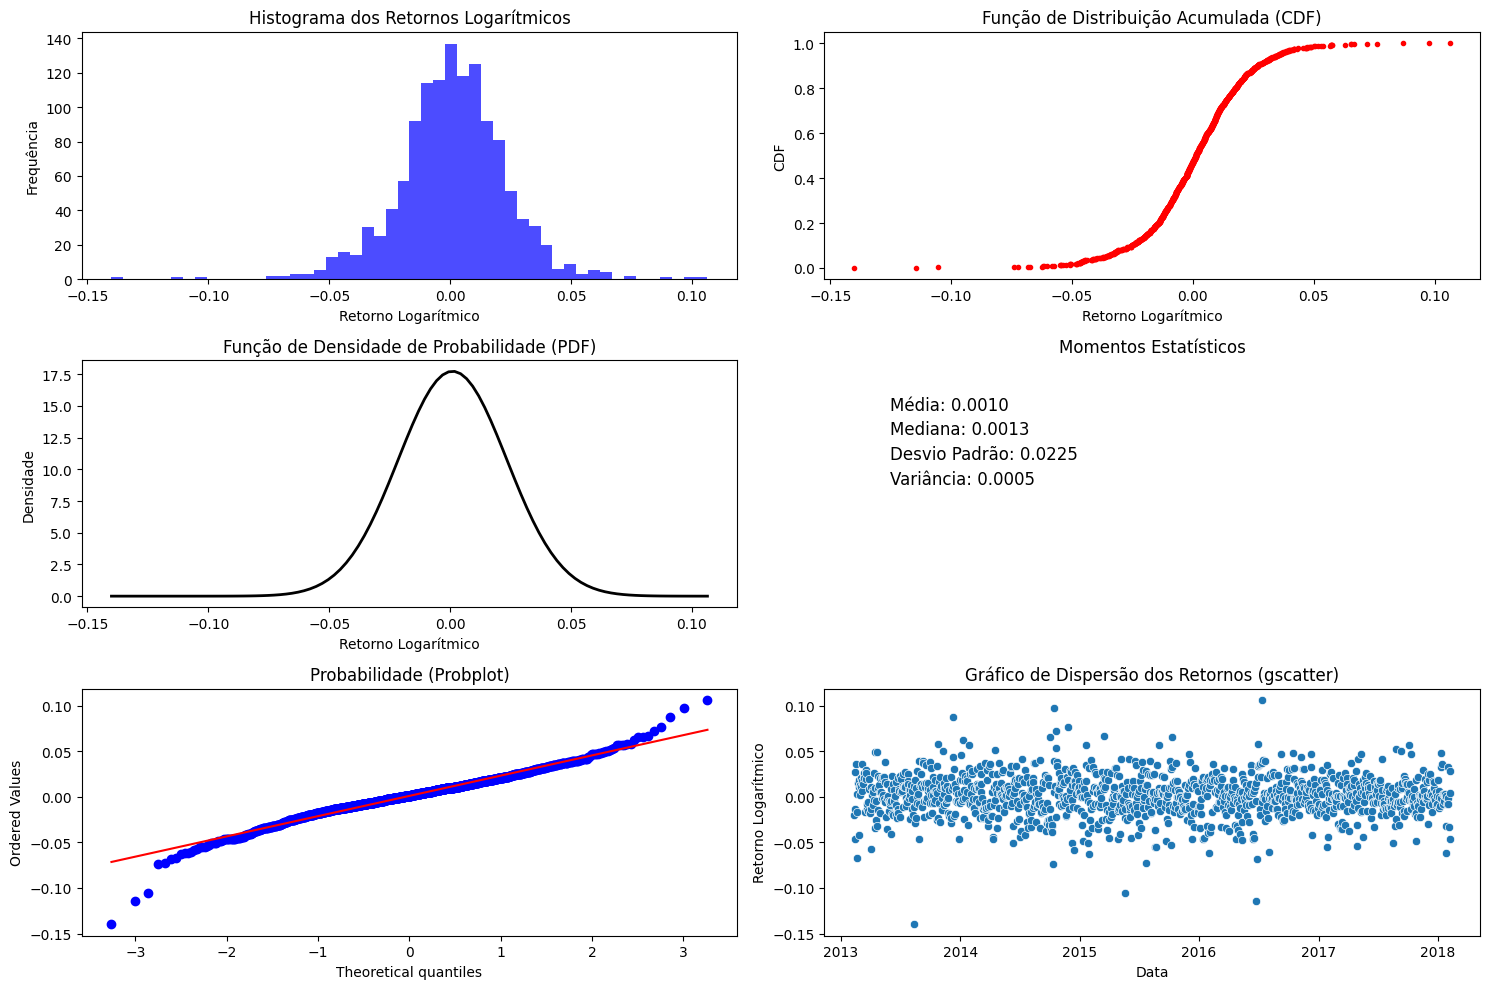

In [ ]:
# Calcular retorno logarítmico: medida comum utilizada em finanças para calcular o crescimento percentual de uma ação ou ativo financeiro ao longo do tempo. Ele é especialmente útil para análise de séries temporais financeiras, como preços de ações, pois possui propriedades matemáticas que facilitam as comparações e cálculos em longos períodos de tempo.
df_aal['log_return'] = np.log(df_aal['close'] / df_aal['close'].shift(1))
df_aal.dropna(inplace=True)

# Inicializar o gráfico
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

# Histograma dos retornos
axs[0, 0].hist(df_aal['log_return'], bins=50, color='blue', alpha=0.7)
axs[0, 0].set_title("Histograma dos Retornos Logarítmicos")
axs[0, 0].set_xlabel("Retorno Logarítmico")
axs[0, 0].set_ylabel("Frequência")

# CDF empírica
ecdf = np.sort(df_aal['log_return'])
cdf = np.arange(1, len(ecdf) + 1) / len(ecdf)
axs[0, 1].plot(ecdf, cdf, marker='.', linestyle='none', color='red')
axs[0, 1].set_title("Função de Distribuição Acumulada (CDF)")
axs[0, 1].set_xlabel("Retorno Logarítmico")
axs[0, 1].set_ylabel("CDF")

# PDF (Densidade de probabilidade) ajustada à normal
xmin, xmax = df_aal['log_return'].min(), df_aal['log_return'].max()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, df_aal['log_return'].mean(), df_aal['log_return'].std())
axs[1, 0].plot(x, p, 'k', linewidth=2)
axs[1, 0].set_title("Função de Densidade de Probabilidade (PDF)")
axs[1, 0].set_xlabel("Retorno Logarítmico")
axs[1, 0].set_ylabel("Densidade")

# Momentos estatísticos
mean_return = df_aal['log_return'].mean() # média
median_return = df_aal['log_return'].median() # mediana
std_return = df_aal['log_return'].std() # desvio padrão
var_return = df_aal['log_return'].var() # variância
axs[1, 1].text(0.1, 0.8, f"Média: {mean_return:.4f}", fontsize=12)
axs[1, 1].text(0.1, 0.7, f"Mediana: {median_return:.4f}", fontsize=12)
axs[1, 1].text(0.1, 0.6, f"Desvio Padrão: {std_return:.4f}", fontsize=12)
axs[1, 1].text(0.1, 0.5, f"Variância: {var_return:.4f}", fontsize=12)
axs[1, 1].axis('off')
axs[1, 1].set_title("Momentos Estatísticos")

# Probabilidade - probplot (distribuição normal)
probplot(df_aal['log_return'], dist="norm", plot=axs[2, 0])
axs[2, 0].set_title("Probabilidade (Probplot)")

# Gráfico de dispersão (gscatter)
sns.scatterplot(x=df_aal['date'], y=df_aal['log_return'], ax=axs[2, 1])
axs[2, 1].set_title("Gráfico de Dispersão dos Retornos (gscatter)")
axs[2, 1].set_xlabel("Data")
axs[2, 1].set_ylabel("Retorno Logarítmico")

# Ajustes finais e exibição
plt.tight_layout()

# Salvar o gráfico gerado
plt.savefig('analises_AAL.png')

# Exibir o gráfico
plt.show()

Correlação entre o volume e os retornos logarítmicos: -0.0719


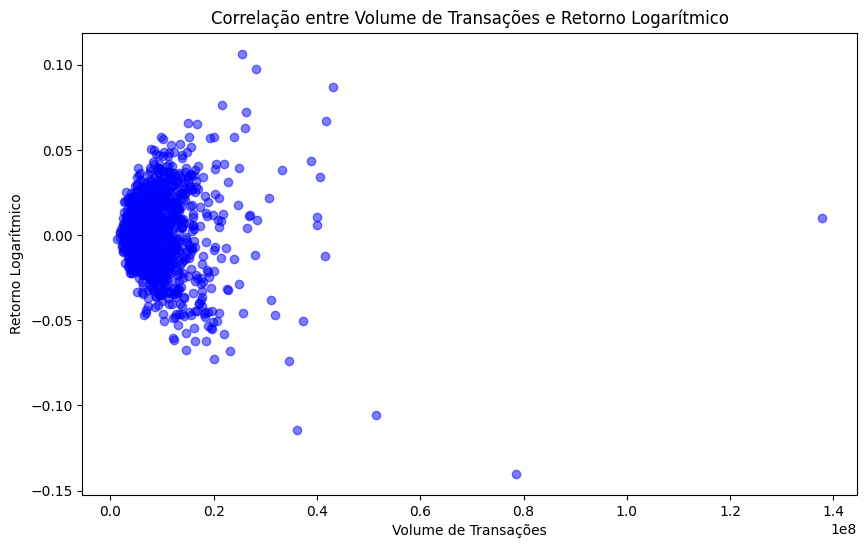

In [ ]:
# Passo 1: Calcular os retornos logarítmicos
# (Este passo já foi feito anteriormente no código)

# Passo 2: Calcular a correlação entre o volume e o retorno logarítmico
correlacao_volume_preco = df_aal['log_return'].corr(df_aal['volume'])

# Exibir a correlação
print(f"Correlação entre o volume e os retornos logarítmicos: {correlacao_volume_preco:.4f}")

# Passo 3: Gerar o gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(df_aal['volume'], df_aal['log_return'], alpha=0.5, color='blue')
plt.title("Correlação entre Volume de Transações e Retorno Logarítmico")
plt.xlabel("Volume de Transações")
plt.ylabel("Retorno Logarítmico")
plt.show()


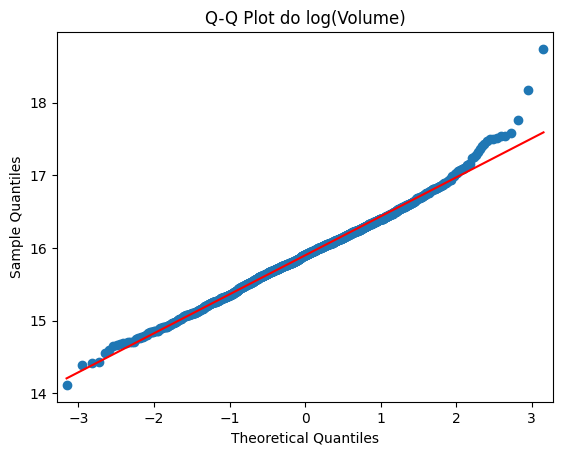

{'Jarque-Bera': {'estatística': np.float64(59.58502602311105),
  'p-valor': np.float64(1.151531962730965e-13)},
 'Lilliefors': {'estatística': np.float64(0.022492726750810155),
  'p-valor': np.float64(0.1895136920622712)},
 'Anderson-Darling': {'estatística': np.float64(0.9328867477843232),
  'críticos': array([0.574, 0.654, 0.785, 0.915, 1.089]),
  'níveis': array([15. , 10. ,  5. ,  2.5,  1. ])},
 'Kolmogorov-Smirnov': {'estatística': np.float64(0.0223967933947552),
  'p-valor': np.float64(0.5457291473220647)},
 't-Test (média log(volume))': {'estatística': np.float64(0.0),
  'p-valor': np.float64(1.0)}}

In [ ]:
# Preparar os dados
df_aal = df[df['Name'] == 'AAL'].copy()
df_aal['date'] = pd.to_datetime(df_aal['date'])
df_aal.sort_values('date', inplace=True)
df_aal['log_return'] = np.log(df_aal['close'] / df_aal['close'].shift(1))
df_aal.dropna(inplace=True)

# Calcular log(volume)
log_volume = np.log(df_aal['volume'])

# Testes estatísticos

# 1. Jarque-Bera Test
jb_stat, jb_p = jarque_bera(log_volume)

# 2. Lilliefors Test (Kolmogorov-Smirnov adaptado)
lillie_stat, lillie_p = lilliefors(log_volume)

# 3. Anderson-Darling Test
ad_result = anderson(log_volume, dist='norm')

# 4. Kolmogorov-Smirnov Test (comparando com normal ajustada)
mu_log, std_log = norm.fit(log_volume)
ks_stat, ks_p = kstest(log_volume, 'norm', args=(mu_log, std_log))

# 5. t-Test (testando se média log(volume) é igual à própria média ajustada)
ttest_stat, ttest_p = ttest_1samp(log_volume, popmean=mu_log)

# 6. Q-Q plot
fig = sm.qqplot(log_volume, line='s')
plt.title("Q-Q Plot do log(Volume)")
plt.show()

# Resultados dos testes
{
    "Jarque-Bera": {"estatística": jb_stat, "p-valor": jb_p},
    "Lilliefors": {"estatística": lillie_stat, "p-valor": lillie_p},
    "Anderson-Darling": {"estatística": ad_result.statistic, "críticos": ad_result.critical_values, "níveis": ad_result.significance_level},
    "Kolmogorov-Smirnov": {"estatística": ks_stat, "p-valor": ks_p},
    "t-Test (média log(volume))": {"estatística": ttest_stat, "p-valor": ttest_p}
}

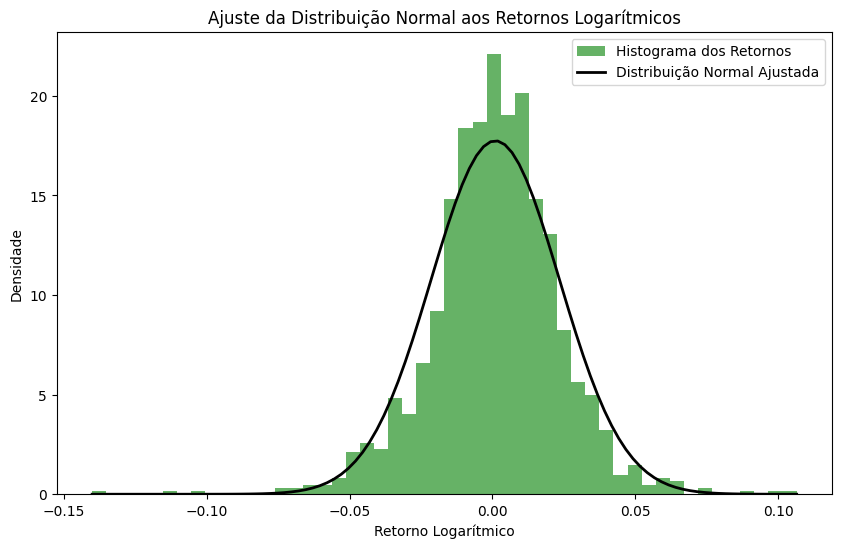

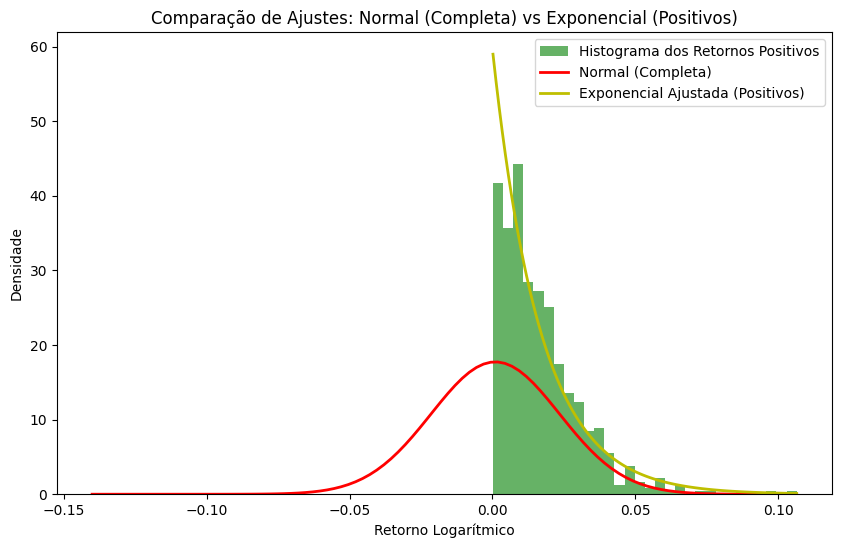

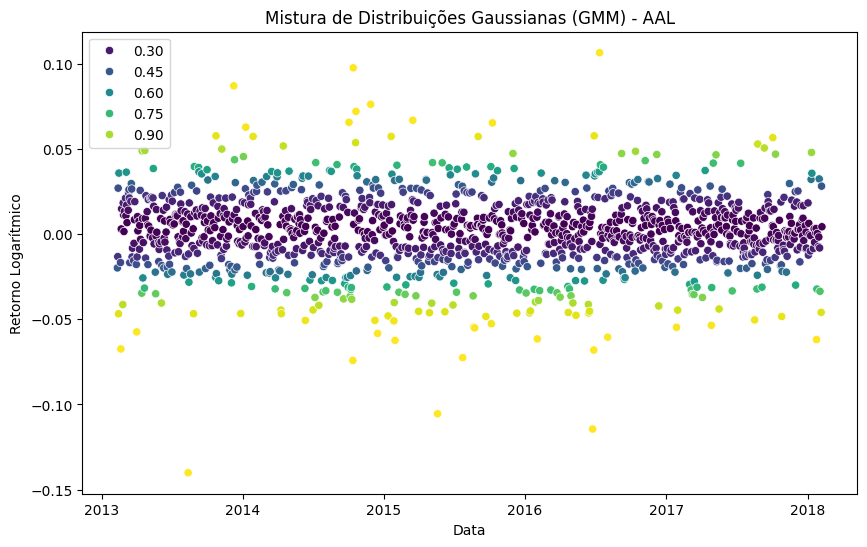

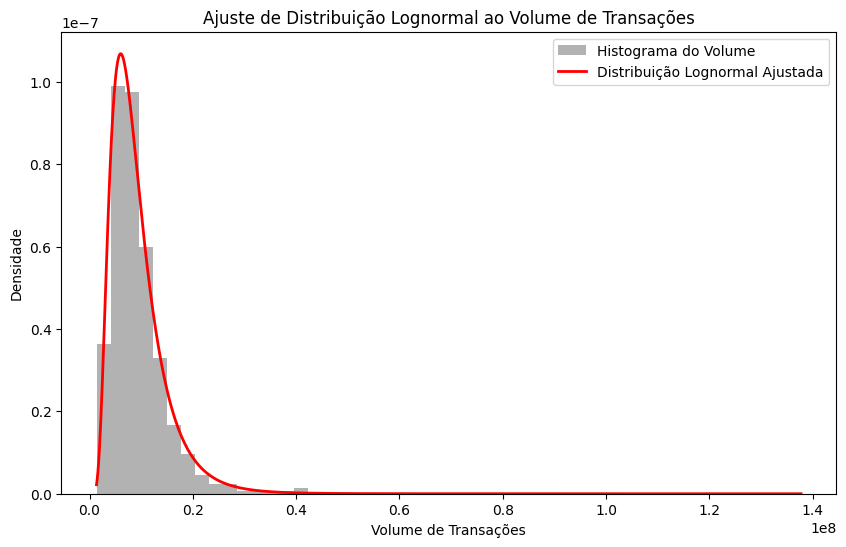

In [ ]:
# 1. Ajuste da distribuição normal aos retornos
# ======================
mu, std = norm.fit(df_aal['log_return'])
x = np.linspace(df_aal['log_return'].min(), df_aal['log_return'].max(), 100)
p = norm.pdf(x, mu, std)

plt.figure(figsize=(10, 6))
plt.hist(df_aal['log_return'], bins=50, density=True, alpha=0.6, color='g', label='Histograma dos Retornos')
plt.plot(x, p, 'k', linewidth=2, label='Distribuição Normal Ajustada')
plt.title("Ajuste da Distribuição Normal aos Retornos Logarítmicos")
plt.xlabel("Retorno Logarítmico")
plt.ylabel("Densidade")
plt.legend()
plt.show()

# ======================
# 2. Ajuste da distribuição exponencial aos retornos (Apenas para retornos positivos)
# ======================
# Filtrar apenas retornos positivos para tentar ajustar a exponencial
positive_returns = df_aal['log_return'][df_aal['log_return'] > 0]

# Verificar se há retornos positivos para ajustar a distribuição
if not positive_returns.empty:
  # Ajustar a distribuição exponencial aos retornos positivos, com loc fixo em 0
  params_expon = expon.fit(positive_returns, floc=0)

  # Criar um linspace para os retornos positivos para plotar a PDF exponencial
  x_positive = np.linspace(positive_returns.min(), positive_returns.max(), 100)
  p_expon = expon.pdf(x_positive, *params_expon)

  plt.figure(figsize=(10, 6))
  # Plotar o histograma APENAS dos retornos positivos para comparação
  plt.hist(positive_returns, bins=30, density=True, alpha=0.6, color='g', label='Histograma dos Retornos Positivos')
  # O plot da normal ainda usa o linspace x original para mostrar o contexto completo
  plt.plot(x, p, 'r-', lw=2, label='Normal (Completa)')
  # Plotar a exponencial ajustada aos retornos positivos
  plt.plot(x_positive, p_expon, 'y-', lw=2, label='Exponencial Ajustada (Positivos)')
  plt.title("Comparação de Ajustes: Normal (Completa) vs Exponencial (Positivos)")
  plt.xlabel("Retorno Logarítmico")
  plt.ylabel("Densidade")
  plt.legend()
  plt.show()
else:
  print("Não há retornos positivos para ajustar a distribuição exponencial.")


# ======================
# 3. Ajuste de mistura de gaussianas (GMM)
# ======================
gmm = GaussianMixture(n_components=2)
gmm.fit(df_aal[['log_return']])
probabilities = gmm.predict_proba(df_aal[['log_return']])

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_aal['date'], y=df_aal['log_return'], hue=probabilities[:, 1], palette='viridis')
plt.title("Mistura de Distribuições Gaussianas (GMM) - AAL")
plt.xlabel("Data")
plt.ylabel("Retorno Logarítmico")
plt.show()

# ======================
# 4. Ajuste da distribuição lognormal ao volume de transações
# ======================
volume = df_aal['volume']
params_volume_lognorm = lognorm.fit(volume, floc=0)
x_vol = np.linspace(volume.min(), volume.max(), 1000)
pdf_volume_lognorm = lognorm.pdf(x_vol, *params_volume_lognorm)

plt.figure(figsize=(10, 6))
plt.hist(volume, bins=50, density=True, alpha=0.6, color='gray', label='Histograma do Volume')
plt.plot(x_vol, pdf_volume_lognorm, 'r-', lw=2, label='Distribuição Lognormal Ajustada')
plt.title("Ajuste de Distribuição Lognormal ao Volume de Transações")
plt.xlabel("Volume de Transações")
plt.ylabel("Densidade")
plt.legend()
plt.show()

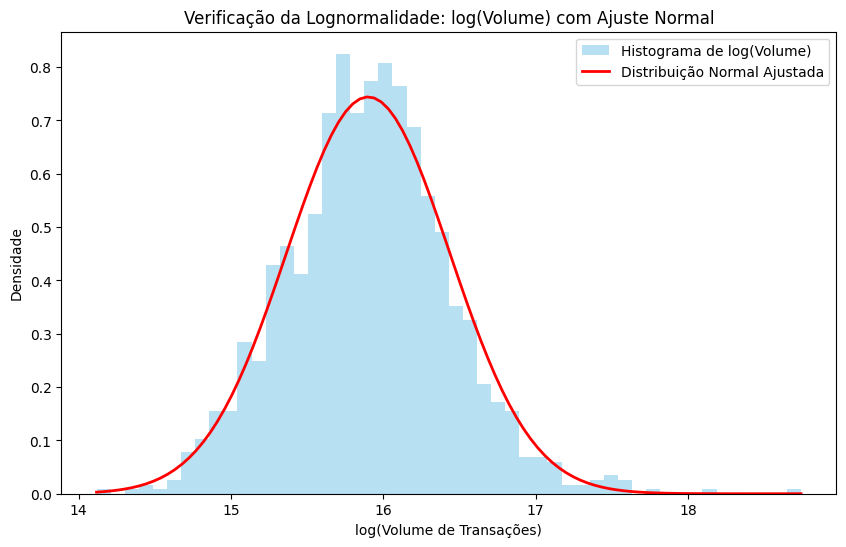

In [ ]:
# Gerar gráfico do log(volume) com sobreposição da distribuição normal
# Calcular o log do volume
log_volume = np.log(df_aal['volume'])

# Ajustar uma distribuição normal ao log do volume
mu_log, std_log = norm.fit(log_volume)
x_log = np.linspace(log_volume.min(), log_volume.max(), 100)
pdf_log = norm.pdf(x_log, mu_log, std_log)

# Plotar o histograma do log(volume) e a curva normal ajustada
plt.figure(figsize=(10, 6))
plt.hist(log_volume, bins=50, density=True, alpha=0.6, color='skyblue', label='Histograma de log(Volume)')
plt.plot(x_log, pdf_log, 'r-', lw=2, label='Distribuição Normal Ajustada')
plt.title("Verificação da Lognormalidade: log(Volume) com Ajuste Normal")
plt.xlabel("log(Volume de Transações)")
plt.ylabel("Densidade")
plt.legend()
plt.show()


In [ ]:
# Converter a coluna de data e definir como índice
df_aal['date'] = pd.to_datetime(df_aal['date'])
df_aal.set_index('date', inplace=True)
df_aal.sort_index(inplace=True)

# Calcular o retorno logarítmico, que é a série que vamos modelar
df_aal['log_return'] = np.log(df_aal['close'] / df_aal['close'].shift(1))

# Remover valores nulos (o primeiro valor será NaN após o cálculo do retorno)
log_returns = df_aal['log_return'].dropna()


# --- 2. Ajustar o Modelo ARIMA ---

# Definimos o modelo ARIMA com ordem (p, d, q)
# p=1: componente autorregressivo de ordem 1
# d=0: sem diferenciação, pois a série de retornos já é estacionária
# q=1: componente de média móvel de ordem 1
model_arima = ARIMA(log_returns, order=(1, 0, 1))

# Ajustar o modelo aos dados
results_arima = model_arima.fit()


# --- 3. Exibir os Resultados ---

# Imprimir o sumário completo do modelo ajustado
print("--- Sumário do Modelo ARIMA(1,0,1) para os Retornos da AAL ---")
print(results_arima.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


--- Sumário do Modelo ARIMA(1,0,1) para os Retornos da AAL ---
                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 1257
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2988.885
Date:                Tue, 05 Aug 2025   AIC                          -5969.770
Time:                        12:23:28   BIC                          -5949.224
Sample:                             0   HQIC                         -5962.048
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.447      0.148      -0.000       0.002
ar.L1          0.2876      0.393      0.732      0.464      -0.482  

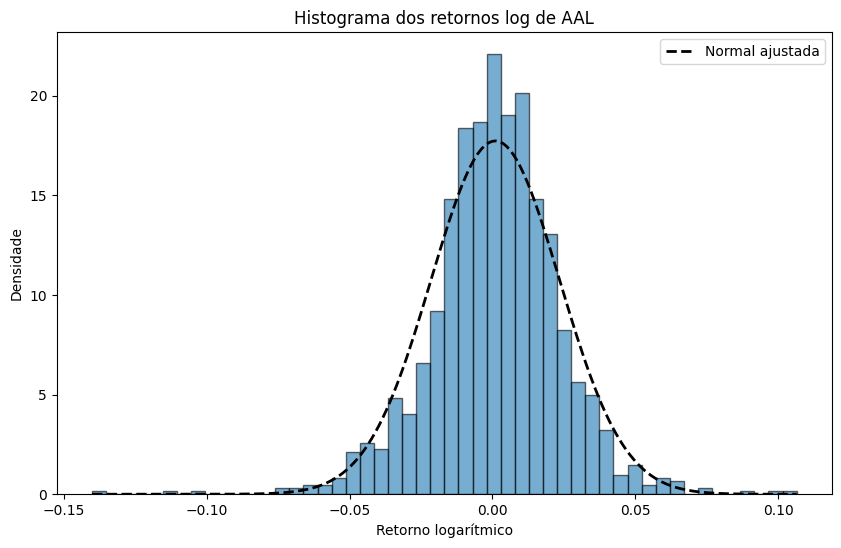

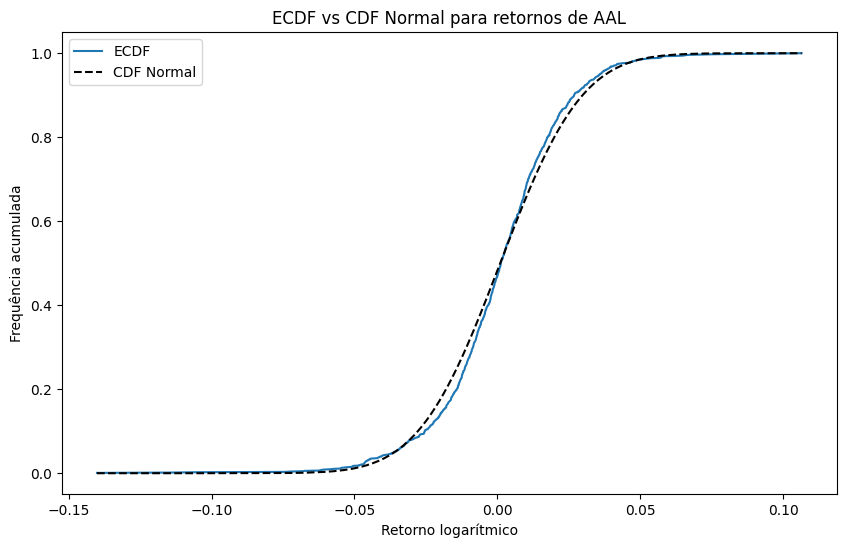

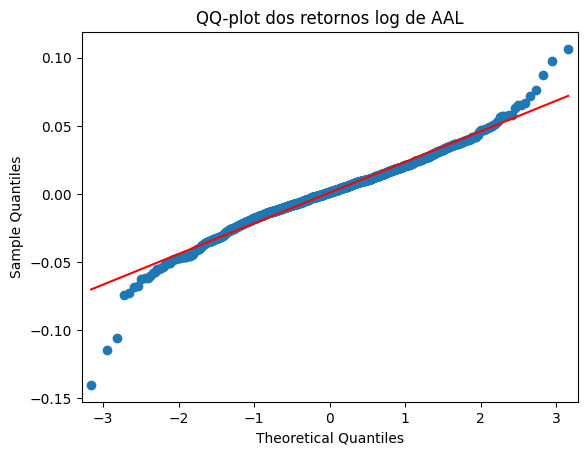

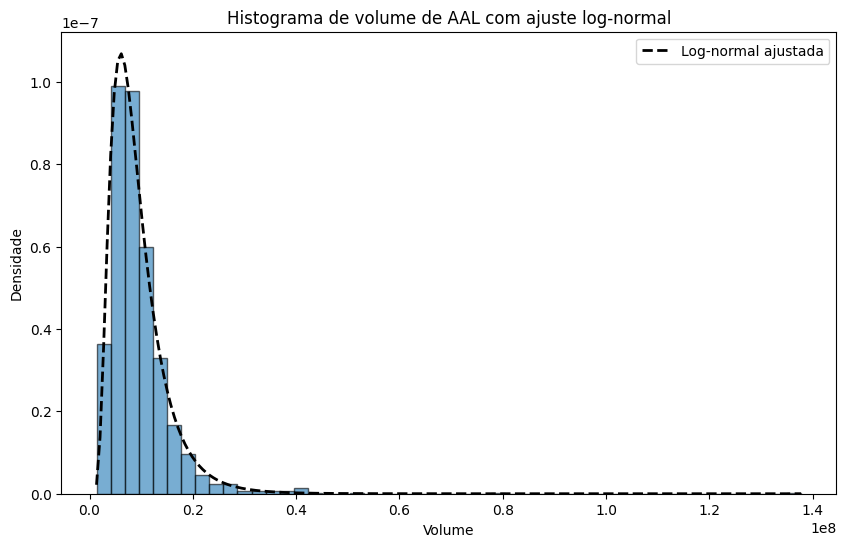

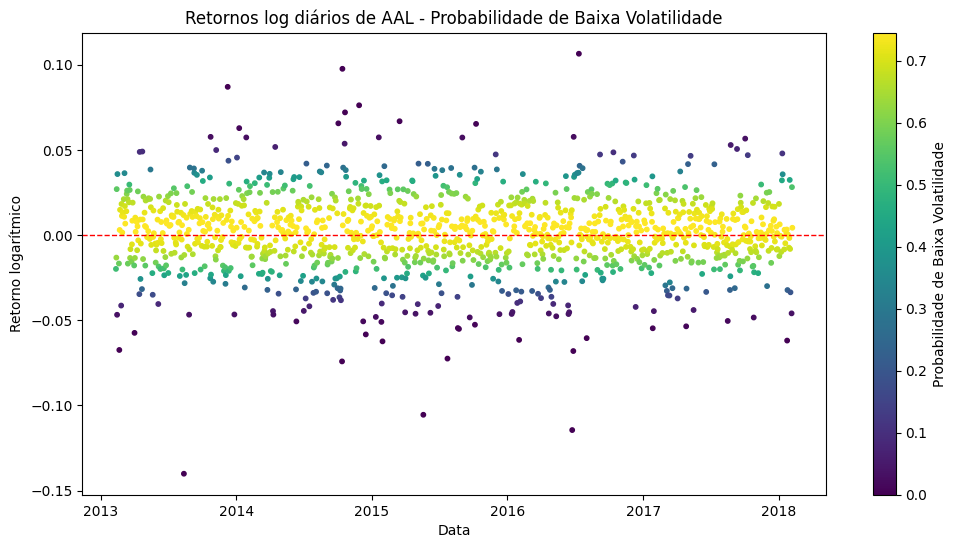

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 1258
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2991.354
Date:                Tue, 05 Aug 2025   AIC                          -5974.707
Time:                        12:23:31   BIC                          -5954.158
Sample:                             0   HQIC                         -5966.985
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.423      0.155      -0.000       0.002
ar.L1          0.3201      0.397      0.806      0.420      -0.458       1.098
ma.L1         -0.2627      0.407     -0.646      0.5

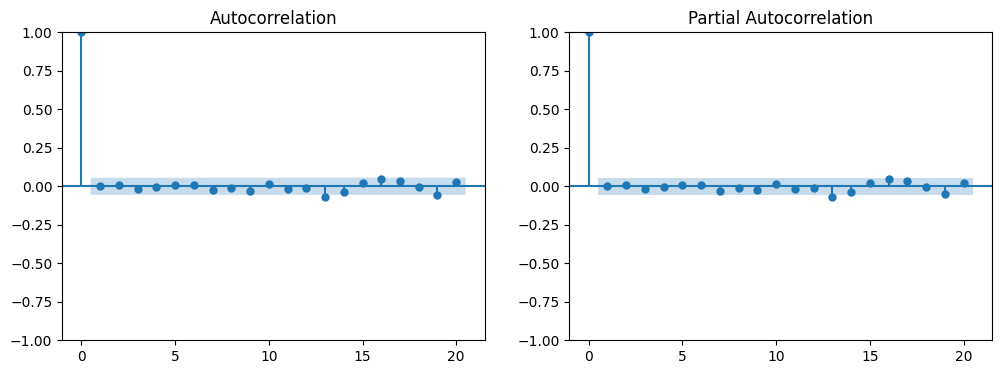

Matriz de transição Up/Down:
return         0         1
return                    
0.0     0.492437  0.507563
1.0     0.453997  0.546003

Matriz de transição Volatilidade Alta/Baixa:
return         0         1
return                    
0.0     0.755037  0.244963
1.0     0.733333  0.266667

Estatísticas retornos AAL:
Média: 0.00099, Desvio Padrão: 0.02249, Variância: 0.00051
Skewness: -0.30, Kurtosis: 5.94
Teste Jarque-Bera: JB=471.38, p=0.000
Correlação retorno x volume: -0.072
Teste KS log(volume): stat=0.02, p=0.543


In [ ]:
# 1. Carregar dados
df = pd.read_csv('all_stocks_5yr.csv', parse_dates=['date'])
df = df.sort_values(['Name', 'date'])

# Selecionar uma ação de exemplo: AAL
ticker = 'AAL'
df_ticker = df[df['Name'] == ticker].set_index('date')

# 2. Calcular retornos logarítmicos
df_ticker['log_price'] = np.log(df_ticker['close'])
df_ticker['return'] = df_ticker['log_price'].diff()

# 3. Estatísticas descritivas dos retornos
mean_ret = df_ticker['return'].mean()
std_ret = df_ticker['return'].std()
var_ret = df_ticker['return'].var()
skew_ret = skew(df_ticker['return'].dropna())
kurt_ret = kurtosis(df_ticker['return'].dropna(), fisher=False)
jb_stat, jb_p = jarque_bera(df_ticker['return'].dropna())

# 4. Histograma + curva Normal
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_ticker['return'].dropna(), bins=50, density=True, alpha=0.6, edgecolor='black')
x = np.linspace(bins.min(), bins.max(), 200)
plt.plot(x, norm.pdf(x, mean_ret, std_ret), 'k--', lw=2, label='Normal ajustada')
plt.title(f'Histograma dos retornos log de {ticker}')
plt.xlabel('Retorno logarítmico')
plt.ylabel('Densidade')
plt.legend()
plt.show()

# 5. CDF empírica vs teórica
returns = df_ticker['return'].dropna().sort_values()
ecdf = np.arange(1, len(returns)+1) / len(returns)
theo_cdf = norm.cdf(returns, loc=mean_ret, scale=std_ret)

plt.figure(figsize=(10, 6))
plt.plot(returns, ecdf, label='ECDF')
plt.plot(returns, theo_cdf, 'k--', label='CDF Normal')
plt.title(f'ECDF vs CDF Normal para retornos de {ticker}')
plt.xlabel('Retorno logarítmico')
plt.ylabel('Frequência acumulada')
plt.legend()
plt.show()

# 6. QQ-plot
sm.qqplot(df_ticker['return'].dropna(), line='s')
plt.title(f'QQ-plot dos retornos log de {ticker}')
plt.show()

# 7. Volume e log-normalidade
vol = df_ticker['volume'].dropna()
shape, loc, scale = lognorm.fit(vol, floc=0)
plt.figure(figsize=(10, 6))
plt.hist(vol, bins=50, density=True, alpha=0.6, edgecolor='black')
x = np.linspace(vol.min(), vol.max(), 200)
plt.plot(x, lognorm.pdf(x, shape, loc, scale), 'k--', lw=2, label='Log-normal ajustada')
plt.title(f'Histograma de volume de {ticker} com ajuste log-normal')
plt.xlabel('Volume')
plt.ylabel('Densidade')
plt.legend()
plt.show()

# Teste KS para log(volume)
ks_stat, ks_p = kstest(np.log(vol), 'norm', args=(np.log(scale), shape))

# 8. Correlação retorno vs volume
corr = df_ticker[['return', 'volume']].dropna().corr().iloc[0,1]

# 9. Ajuste de GMM para retornos
ret = df_ticker['return'].dropna().values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=42).fit(ret)
probs = gmm.predict_proba(ret)
# identificar componente de baixa volatilidade (menor variance)
vars_ = gmm.covariances_.flatten()
low_vol_comp = np.argmin(vars_)

# Scatter temporal colorido por probabilidade de baixa volatilidade
dates = df_ticker['return'].dropna().index
plt.figure(figsize=(12, 6))
plt.scatter(dates, ret.flatten(), c=probs[:, low_vol_comp], cmap='viridis', s=10)
plt.colorbar(label='Probabilidade de Baixa Volatilidade')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title(f'Retornos log diários de {ticker} - Probabilidade de Baixa Volatilidade')
plt.xlabel('Data')
plt.ylabel('Retorno logarítmico')
plt.show()

# 10. Ajuste de ARIMA(1,0,0) nos retornos
model = ARIMA(df_ticker['return'].dropna(), order=(1, 0, 1))
res = model.fit()
print(res.summary())

# ACF e PACF dos resíduos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(res.resid, lags=20, ax=ax1)
plot_pacf(res.resid, lags=20, ax=ax2)
plt.show()

# 11. Cadeia de Markov simples (Up/Down)
direction = (df_ticker['return'] > 0).astype(int)  # 1=Up, 0=Down
transitions = pd.crosstab(direction.shift(1).dropna(), direction.dropna(), normalize='index')
print("Matriz de transição Up/Down:")
print(transitions)

# 12. Cadeia de Markov para volatilidade (|return| > 75º percentil)
threshold = np.percentile(np.abs(ret), 75)
vol_state = (np.abs(df_ticker['return']) > threshold).astype(int)
vol_trans = pd.crosstab(vol_state.shift(1).dropna(), vol_state.dropna(), normalize='index')
print("\nMatriz de transição Volatilidade Alta/Baixa:")
print(vol_trans)

# Exibir estatísticas principais
print(f"\nEstatísticas retornos {ticker}:")
print(f"Média: {mean_ret:.5f}, Desvio Padrão: {std_ret:.5f}, Variância: {var_ret:.5f}")
print(f"Skewness: {skew_ret:.2f}, Kurtosis: {kurt_ret:.2f}")
print(f"Teste Jarque-Bera: JB={jb_stat:.2f}, p={jb_p:.3f}")
print(f"Correlação retorno x volume: {corr:.3f}")
print(f"Teste KS log(volume): stat={ks_stat:.2f}, p={ks_p:.3f}")

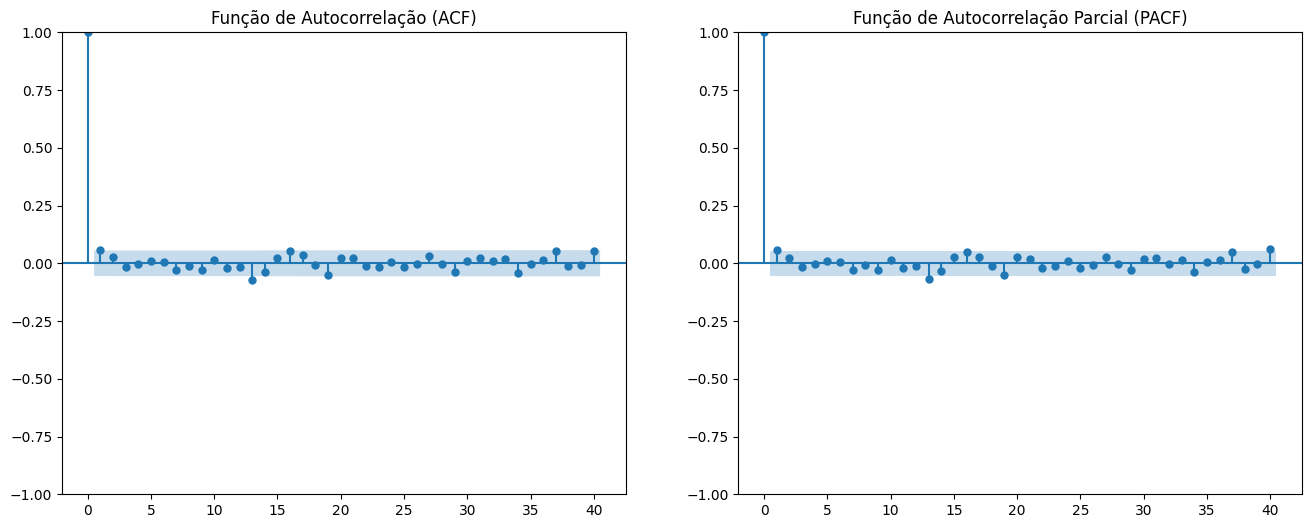

In [ ]:
# Importar as funções de plotagem
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Supondo que 'log_returns' já foi calculado e os NaNs removidos
log_returns = df_aal['log_return'].dropna()

# Criar os gráficos ACF e PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plotar o ACF
plot_acf(log_returns, lags=40, ax=ax1)
ax1.set_title('Função de Autocorrelação (ACF)')

# Plotar o PACF
plot_pacf(log_returns, lags=40, ax=ax2)
ax2.set_title('Função de Autocorrelação Parcial (PACF)')

plt.show()

--- 1. Carregando e preparando os dados ---
Dados carregados e retornos logarítmicos calculados com sucesso.

--- 2. Analisando ACF e PACF para selecionar a ordem (p,q) ---


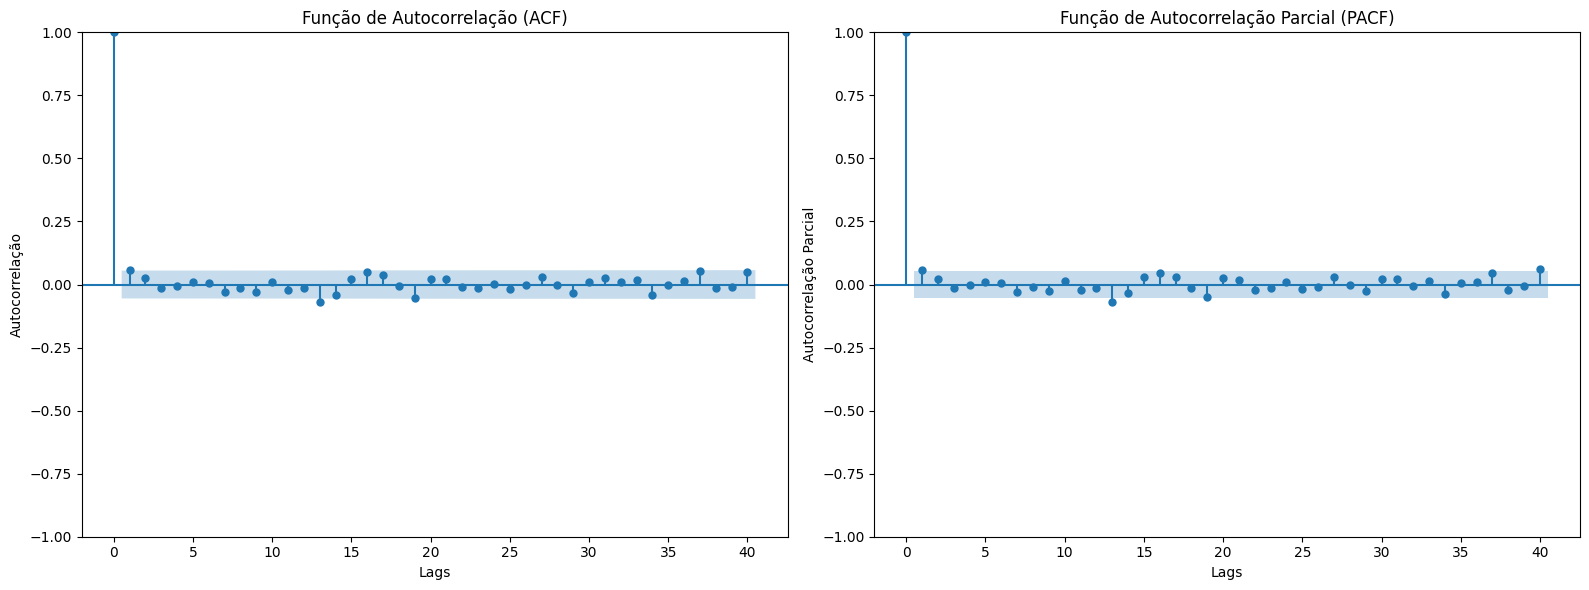

Observação: Em dados financeiros, os gráficos ACF e PACF raramente são claros.
Eles frequentemente mostram alguns lags significativos, sugerindo que ordens baixas como (1,1), (2,1), (1,2) etc., são bons pontos de partida.

--- 3. Ajustando o modelo ARIMA(1,0,1) ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



--- Sumário do Modelo ARIMA ---
                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 1258
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2991.354
Date:                Tue, 05 Aug 2025   AIC                          -5974.707
Time:                        12:23:33   BIC                          -5954.158
Sample:                             0   HQIC                         -5966.985
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.423      0.155      -0.000       0.002
ar.L1          0.3201      0.397      0.806      0.420      -0.458       1.098
ma.L1         -0.26

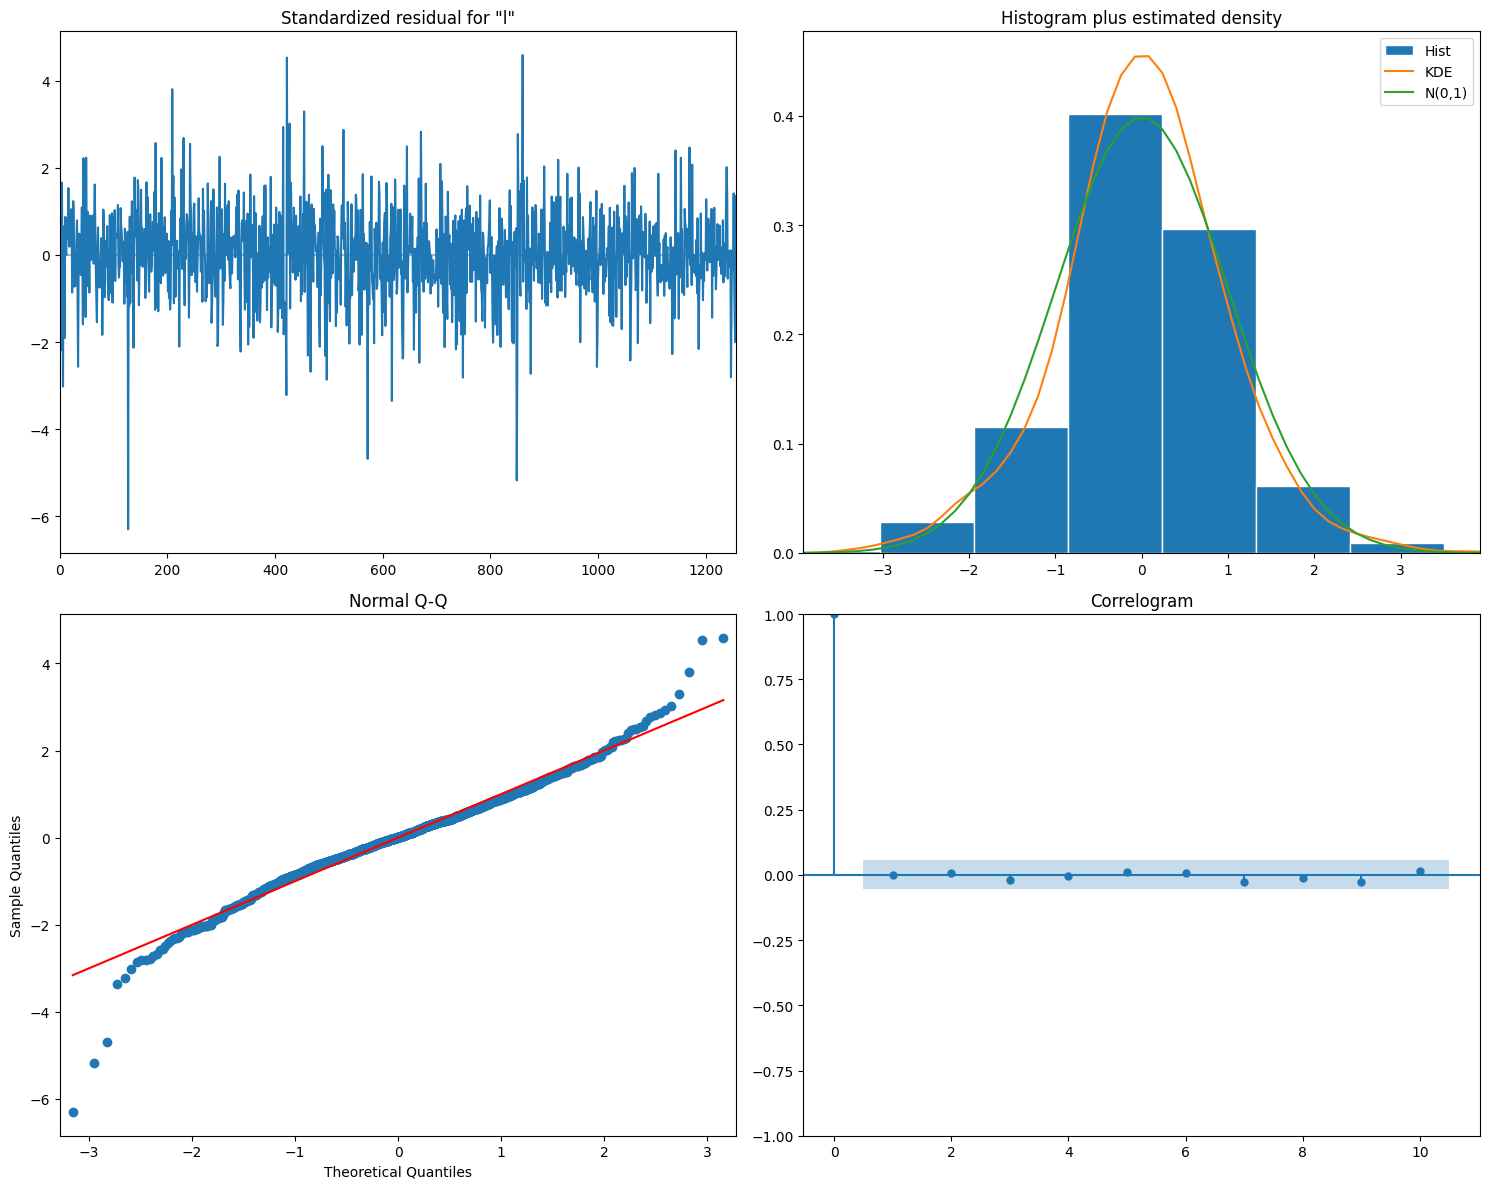

Análise dos Gráficos de Diagnóstico:
 - 'Standardized residual': Os resíduos devem flutuar em torno de zero, sem padrões óbvios (como volatilidade crescente).
 - 'Histogram plus estimated density': O histograma dos resíduos deve se assemelhar a uma distribuição normal (curva N(0,1)).
 - 'Normal Q-Q': Os pontos devem seguir a linha reta vermelha, indicando normalidade.
 - 'Correlogram' (ACF): Não deve haver barras significativas após o lag 0, indicando que não há autocorrelação remanescente.

--- 5. Verificando a presença de efeitos ARCH/GARCH (volatilidade condicional) ---
Se o modelo ARIMA capturou bem a média, os resíduos não devem ser correlacionados.
No entanto, a volatilidade (variância) pode ainda ser dependente do tempo.
Verificamos isso analisando a autocorrelação dos RESÍDUOS AO QUADRADO.


<Figure size 1000x600 with 0 Axes>

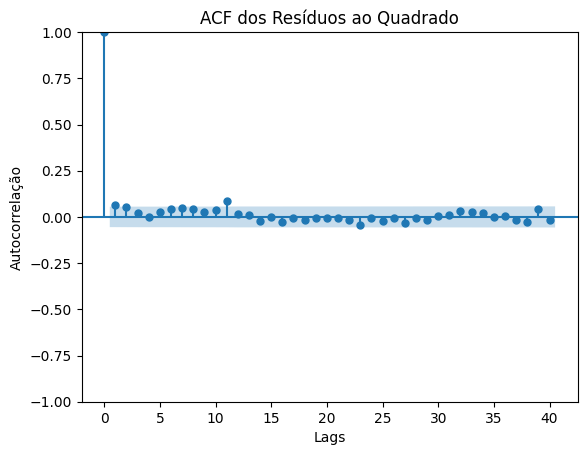


Análise Final:
Se o gráfico 'ACF dos Resíduos ao Quadrado' mostra lags significativos (barras fora da área azul),
isso é uma forte evidência de efeitos ARCH/GARCH. Significa que a volatilidade é autocorrelacionada (volatility clustering).
Este resultado justifica plenamente o próximo passo da análise: ajustar um modelo GARCH para capturar a dinâmica da variância.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# --- Bloco 1: Carregamento e Preparação dos Dados ---
print("--- 1. Carregando e preparando os dados ---")

# Carregar o arquivo CSV
try:
    df = pd.read_csv('all_stocks_5yr.csv')
except FileNotFoundError:
    print("Erro: Arquivo 'all_stocks_5yr.csv' não encontrado.")
    print("Por favor, certifique-se de que o arquivo está no mesmo diretório que o script.")
    # Encerra o script se o arquivo não for encontrado
    exit()


# Filtrar dados da AAL, converter data e ordenar
df_aal = df[df['Name'] == 'AAL'].copy()
df_aal['date'] = pd.to_datetime(df_aal['date'])
df_aal.set_index('date', inplace=True)
df_aal.sort_index(inplace=True)

# Calcular o retorno logarítmico (nossa série estacionária)
df_aal['log_return'] = np.log(df_aal['close'] / df_aal['close'].shift(1))

# Remover valores nulos (o primeiro valor será NaN)
log_returns = df_aal['log_return'].dropna()

print("Dados carregados e retornos logarítmicos calculados com sucesso.\n")


# --- Bloco 2: Análise para Seleção da Ordem (p, q) ---
print("--- 2. Analisando ACF e PACF para selecionar a ordem (p,q) ---")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plotar o ACF para ajudar a determinar a ordem q (MA)
# Procuramos um corte brusco nos lags
plot_acf(log_returns, lags=40, ax=ax1)
ax1.set_title('Função de Autocorrelação (ACF)')
ax1.set_xlabel('Lags')
ax1.set_ylabel('Autocorrelação')

# Plotar o PACF para ajudar a determinar a ordem p (AR)
# Procuramos um corte brusco nos lags
plot_pacf(log_returns, lags=40, ax=ax2)
ax2.set_title('Função de Autocorrelação Parcial (PACF)')
ax2.set_xlabel('Lags')
ax2.set_ylabel('Autocorrelação Parcial')

plt.tight_layout()
plt.show()

print("Observação: Em dados financeiros, os gráficos ACF e PACF raramente são claros.")
print("Eles frequentemente mostram alguns lags significativos, sugerindo que ordens baixas como (1,1), (2,1), (1,2) etc., são bons pontos de partida.\n")


# --- Bloco 3: Ajuste do Modelo ARIMA ---
# Com base na análise (ou como ponto de partida), ajustamos um modelo.
# O ARIMA(1,0,1) do seu código original é um candidato comum.
p, d, q = 1, 0, 1
print(f"--- 3. Ajustando o modelo ARIMA({p},{d},{q}) ---")

model = ARIMA(log_returns, order=(p, d, q))
results = model.fit()

# Exibir o sumário completo do modelo
print("\n--- Sumário do Modelo ARIMA ---")
print(results.summary())
print("\nAnálise do Sumário:")
print(" - Verifique os p-valores (P>|z|) dos coeficientes (ar.L1, ma.L1). Valores < 0.05 indicam que são significativos.")
print(" - Observe os critérios de informação (AIC, BIC). Modelos com valores menores são geralmente preferíveis.\n")


# --- Bloco 4: Diagnóstico do Modelo (Análise dos Resíduos) ---
print("--- 4. Realizando o diagnóstico dos resíduos do modelo ---")
# Um bom modelo deve ter resíduos que se comportam como ruído branco (aleatórios e não correlacionados).

# O Statsmodels oferece uma função de plotagem de diagnóstico completa
fig = results.plot_diagnostics(figsize=(15, 12))
plt.tight_layout()
plt.show()

print("Análise dos Gráficos de Diagnóstico:")
print(" - 'Standardized residual': Os resíduos devem flutuar em torno de zero, sem padrões óbvios (como volatilidade crescente).")
print(" - 'Histogram plus estimated density': O histograma dos resíduos deve se assemelhar a uma distribuição normal (curva N(0,1)).")
print(" - 'Normal Q-Q': Os pontos devem seguir a linha reta vermelha, indicando normalidade.")
print(" - 'Correlogram' (ACF): Não deve haver barras significativas após o lag 0, indicando que não há autocorrelação remanescente.\n")


# --- Bloco 5: Verificação de Efeitos ARCH (A Ponte para o GARCH) ---
print("--- 5. Verificando a presença de efeitos ARCH/GARCH (volatilidade condicional) ---")
print("Se o modelo ARIMA capturou bem a média, os resíduos não devem ser correlacionados.")
print("No entanto, a volatilidade (variância) pode ainda ser dependente do tempo.")
print("Verificamos isso analisando a autocorrelação dos RESÍDUOS AO QUADRADO.")

# Calcular os resíduos ao quadrado
squared_residuals = results.resid**2

# Plotar o ACF dos resíduos ao quadrado
plt.figure(figsize=(10, 6))
plot_acf(squared_residuals, lags=40)
plt.title('ACF dos Resíduos ao Quadrado')
plt.xlabel('Lags')
plt.ylabel('Autocorrelação')
plt.show()

print("\nAnálise Final:")
print("Se o gráfico 'ACF dos Resíduos ao Quadrado' mostra lags significativos (barras fora da área azul),")
print("isso é uma forte evidência de efeitos ARCH/GARCH. Significa que a volatilidade é autocorrelacionada (volatility clustering).")
print("Este resultado justifica plenamente o próximo passo da análise: ajustar um modelo GARCH para capturar a dinâmica da variância.")

In [ ]:
# Supondo returns already defined:
direction = (returns > 0).astype(int)
trans_dir = pd.crosstab(direction.shift(1).dropna(),
                        direction.dropna(),
                        normalize='index')
print("Matriz de transição Up/Down:")
print(trans_dir)

# Estados de volatilidade
threshold = np.percentile(np.abs(returns), 75)
vol_state = (np.abs(returns) > threshold).astype(int)
trans_vol = pd.crosstab(vol_state.shift(1).dropna(),
                        vol_state.dropna(),
                        normalize='index')
print("\nMatriz de transição Volatilidade Alta/Baixa:")
print(trans_vol)


Matriz de transição Up/Down:
return         0         1
return                    
0.0     0.998316  0.001684
1.0     0.000000  1.000000

Matriz de transição Volatilidade Alta/Baixa:
return         0         1
return                    
0.0     0.998940  0.001060
1.0     0.003185  0.996815


In [ ]:
import pandas as pd
import numpy as np

# --- Bloco 1: Carregamento e Preparação dos Dados ---
print("--- 1. Carregando e preparando os dados ---")

# Carregar o arquivo CSV
try:
    df = pd.read_csv('all_stocks_5yr.csv')
except FileNotFoundError:
    print("Erro: Arquivo 'all_stocks_5yr.csv' não encontrado.")
    exit()

# Filtrar dados da AAL, converter data e ordenar
df_aal = df[df['Name'] == 'AAL'].copy()
df_aal['date'] = pd.to_datetime(df_aal['date'])
df_aal.set_index('date', inplace=True)
df_aal.sort_index(inplace=True)

# Calcular o retorno logarítmico
df_aal['log_return'] = np.log(df_aal['close'] / df_aal['close'].shift(1))
log_returns = df_aal['log_return'].dropna()

print("Dados preparados com sucesso.\n")


# --- Bloco 2: Cadeia de Markov para Direção do Preço (Alta/Baixa) ---
print("--- 2. Modelo de Markov para Direção do Preço (Estados: Alta/Baixa) ---")

# 1. Definir os Estados
# Estado 0: Dia de Baixa (retorno <= 0)
# Estado 1: Dia de Alta (retorno > 0)
price_states = (log_returns > 0).astype(int)

# 2. Calcular a Matriz de Transição de Probabilidades
# pd.crosstab conta as ocorrências de transição de um dia (t-1) para o outro (t)
# normalize='index' converte essas contagens em probabilidades para cada estado inicial
price_transition_matrix = pd.crosstab(
    price_states.shift(1),
    price_states,
    normalize='index'
)

# Renomear para clareza
price_transition_matrix.index.name = 'Estado Atual (t-1)'
price_transition_matrix.columns.name = 'Próximo Estado (t)'
price_transition_matrix.index = ['Baixa', 'Alta']
price_transition_matrix.columns = ['Baixa', 'Alta']


print("\nMatriz de Transição de Probabilidades (Direção do Preço):")
print(price_transition_matrix)

# 3. Como usar para "previsão"
today_is_alta = price_transition_matrix.loc['Alta']
print(f"\nExemplo de Previsão (Direção):")
print(f"Se hoje foi um dia de ALTA, a probabilidade de amanhã ser de ALTA é {today_is_alta['Alta']:.2%} e de BAIXA é {today_is_alta['Baixa']:.2%}.\n")


# --- Bloco 3: Cadeia de Markov para Volatilidade (Alta/Baixa) ---
print("--- 3. Modelo de Markov para Regime de Volatilidade (Estados: Alta/Baixa Vol.) ---")

# 1. Definir os Estados
# Usamos um percentil para separar os regimes. O 75º é uma escolha comum.
abs_returns = np.abs(log_returns)
volatility_threshold = abs_returns.quantile(0.75)

# Estado 0: Baixa Volatilidade (retorno absoluto <= threshold)
# Estado 1: Alta Volatilidade (retorno absoluto > threshold)
vol_states = (abs_returns > volatility_threshold).astype(int)

# 2. Calcular a Matriz de Transição
vol_transition_matrix = pd.crosstab(
    vol_states.shift(1),
    vol_states,
    normalize='index'
)

# Renomear para clareza
vol_transition_matrix.index.name = 'Estado Atual (t-1)'
vol_transition_matrix.columns.name = 'Próximo Estado (t)'
vol_transition_matrix.index = ['Baixa Volatilidade', 'Alta Volatilidade']
vol_transition_matrix.columns = ['Baixa Volatilidade', 'Alta Volatilidade']

print("\nMatriz de Transição de Probabilidades (Regime de Volatilidade):")
print(vol_transition_matrix)

# 3. Como usar para "previsão"
today_is_alta_vol = vol_transition_matrix.loc['Alta Volatilidade']
prob_permanecer_alta_vol = today_is_alta_vol['Alta Volatilidade']

print(f"\nExemplo de Previsão (Volatilidade):")
print(f"O limiar que define alta volatilidade é um retorno absoluto de {volatility_threshold:.2%}.")
print(f"Se hoje foi um dia de ALTA VOLATILIDADE, a probabilidade de amanhã continuar em ALTA VOLATILIDADE é de {prob_permanecer_alta_vol:.2%}.")

if prob_permanecer_alta_vol > 0.25: # A probabilidade esperada seria 25% se não houvesse dependência
    print("Este resultado sugere a presença de 'volatility clustering', um conceito fundamental em finanças.")

--- 1. Carregando e preparando os dados ---
Dados preparados com sucesso.

--- 2. Modelo de Markov para Direção do Preço (Estados: Alta/Baixa) ---

Matriz de Transição de Probabilidades (Direção do Preço):
          Baixa      Alta
Baixa  0.491582  0.508418
Alta   0.453997  0.546003

Exemplo de Previsão (Direção):
Se hoje foi um dia de ALTA, a probabilidade de amanhã ser de ALTA é 54.60% e de BAIXA é 45.40%.

--- 3. Modelo de Markov para Regime de Volatilidade (Estados: Alta/Baixa Vol.) ---

Matriz de Transição de Probabilidades (Regime de Volatilidade):
                    Baixa Volatilidade  Alta Volatilidade
Baixa Volatilidade            0.754777           0.245223
Alta Volatilidade             0.733333           0.266667

Exemplo de Previsão (Volatilidade):
O limiar que define alta volatilidade é um retorno absoluto de 2.28%.
Se hoje foi um dia de ALTA VOLATILIDADE, a probabilidade de amanhã continuar em ALTA VOLATILIDADE é de 26.67%.
Este resultado sugere a presença de 'volatility

In [ ]:
import pandas as pd
import numpy as np

# --- Bloco 1: Carregamento e Preparação dos Dados ---
print("--- 1. Carregando e preparando os dados ---")

# Carregar o arquivo CSV
try:
    df = pd.read_csv('all_stocks_5yr.csv')
except FileNotFoundError:
    print("Erro: Arquivo 'all_stocks_5yr.csv' não encontrado.")
    exit()

# Isolar dados da AAL, processar datas e ordenar
df_aal = df[df['Name'] == 'AAL'].copy()
df_aal['date'] = pd.to_datetime(df_aal['date'])
df_aal.set_index('date', inplace=True)
df_aal.sort_index(inplace=True)

# Calcular o retorno logarítmico
df_aal['log_return'] = np.log(df_aal['close'] / df_aal['close'].shift(1))

# Obter as duas séries que usaremos: retorno logarítmico e volume
log_returns = df_aal['log_return'].dropna()
volume = df_aal['volume'].loc[log_returns.index] # Garante que o volume corresponda aos dias com retorno


print("Dados preparados com sucesso.\n")


# --- Bloco 2: Definição dos Estados Combinados (Retorno + Volume) ---
print("--- 2. Definindo os 4 estados (Retorno + Volume) ---")

# 1. Definir o limiar do volume (mediana)
volume_threshold = volume.median()
print(f"O limiar para 'Alto Volume' é a mediana: {volume_threshold:,.0f} ações negociadas.")

# 2. Criar as condições para cada estado
# Condição de Retorno
is_up_day = log_returns > 0
is_down_day = log_returns <= 0

# Condição de Volume
is_high_volume = volume > volume_threshold
is_low_volume = volume <= volume_threshold

# 3. Atribuir um estado numérico para cada dia
# Usamos np.select para uma atribuição clara baseada nas combinações de condições
conditions = [
    is_down_day & is_low_volume,   # Estado 0
    is_down_day & is_high_volume,  # Estado 1
    is_up_day & is_low_volume,     # Estado 2
    is_up_day & is_high_volume     # Estado 3
]
state_values = [0, 1, 2, 3]
combined_states = pd.Series(np.select(conditions, state_values, default=np.nan), index=log_returns.index)

print("Estados definidos com sucesso.\n")


# --- Bloco 3: Cálculo e Exibição da Matriz de Transição ---
print("--- 3. Calculando a Matriz de Transição de 4 Estados ---")

# Calcular a matriz de transição usando crosstab
transition_matrix = pd.crosstab(
    combined_states.shift(1),
    combined_states,
    normalize='index'
)

# Definir nomes claros para os estados para melhor visualização
state_names = [
    'Baixa / Baixo Vol.',
    'Baixa / Alto Vol.',
    'Alta / Baixo Vol.',
    'Alta / Alto Vol.'
]

transition_matrix.index.name = 'Estado Atual (t-1)'
transition_matrix.columns.name = 'Próximo Estado (t)'
transition_matrix.index = state_names
transition_matrix.columns = state_names

# Exibir a matriz de transição formatada em percentual
print("\nMatriz de Transição de Probabilidades (Retorno + Volume):")
print((transition_matrix * 100).round(2).astype(str) + '%')


# --- Bloco 4: Como Interpretar e Usar a Matriz ---
print("\n--- 4. Como Interpretar a Matriz de Transição ---")
print("Cada linha representa o estado de HOJE (t-1) e mostra a probabilidade de transição para cada um dos quatro estados AMANHÃ (t).")

# Exemplo 1: O que acontece depois de um dia de pânico (queda com alto volume)?
prob_after_panic = transition_matrix.loc['Baixa / Alto Vol.']
print("\nExemplo 1: Análise após um dia de 'Baixa / Alto Vol.' (pânico):")
print(f" - Prob. de outro dia de 'Baixa / Alto Vol.': {prob_after_panic['Baixa / Alto Vol.']:.2%}")
print(f" - Prob. de um dia de 'Alta / Alto Vol.' (reversão forte): {prob_after_panic['Alta / Alto Vol.']:.2%}")

# Exemplo 2: O que acontece depois de um dia de euforia (alta com alto volume)?
prob_after_euphoria = transition_matrix.loc['Alta / Alto Vol.']
print("\nExemplo 2: Análise após um dia de 'Alta / Alto Vol.' (euforia):")
print(f" - Prob. de continuar em 'Alta / Alto Vol.': {prob_after_euphoria['Alta / Alto Vol.']:.2%}")
print(f" - Prob. de um dia de 'Baixa / Alto Vol.' (reversão forte): {prob_after_euphoria['Baixa / Alto Vol.']:.2%}")

--- 1. Carregando e preparando os dados ---
Dados preparados com sucesso.

--- 2. Definindo os 4 estados (Retorno + Volume) ---
O limiar para 'Alto Volume' é a mediana: 8,105,176 ações negociadas.
Estados definidos com sucesso.

--- 3. Calculando a Matriz de Transição de 4 Estados ---

Matriz de Transição de Probabilidades (Retorno + Volume):
                   Baixa / Baixo Vol. Baixa / Alto Vol. Alta / Baixo Vol.  \
Baixa / Baixo Vol.             33.33%            12.79%            42.09%   
Baixa / Alto Vol.              11.45%            40.74%            11.45%   
Alta / Baixo Vol.              36.86%             8.16%            40.18%   
Alta / Alto Vol.               12.65%            33.13%            12.05%   

                   Alta / Alto Vol.  
Baixa / Baixo Vol.           11.78%  
Baixa / Alto Vol.            36.36%  
Alta / Baixo Vol.             14.8%  
Alta / Alto Vol.             42.17%  

--- 4. Como Interpretar a Matriz de Transição ---
Cada linha representa o esta

--- 1. Carregando e preparando os dados ---
Dados preparados.

--- 2. Gráficos da análise ARIMA ---
Gráfico 1: ACF e PACF dos Retornos Logarítmicos


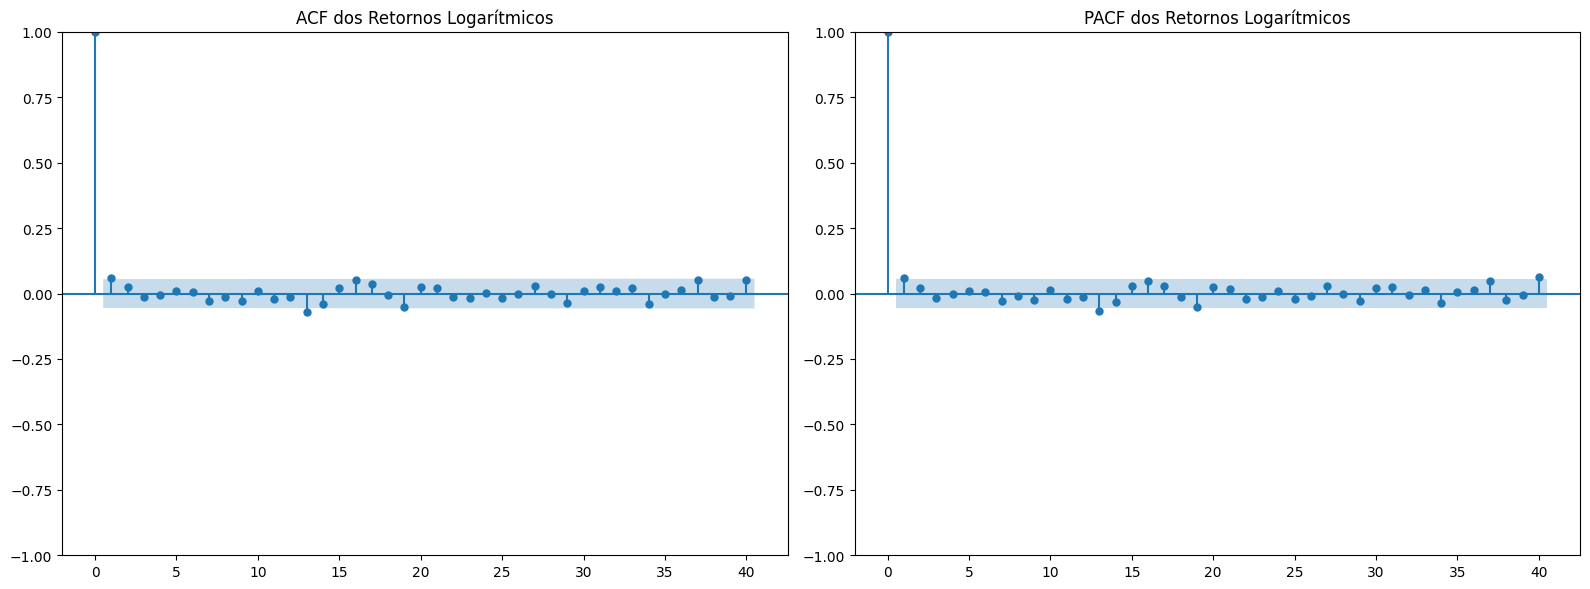

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Gráfico 2: Diagnóstico do Modelo ARIMA


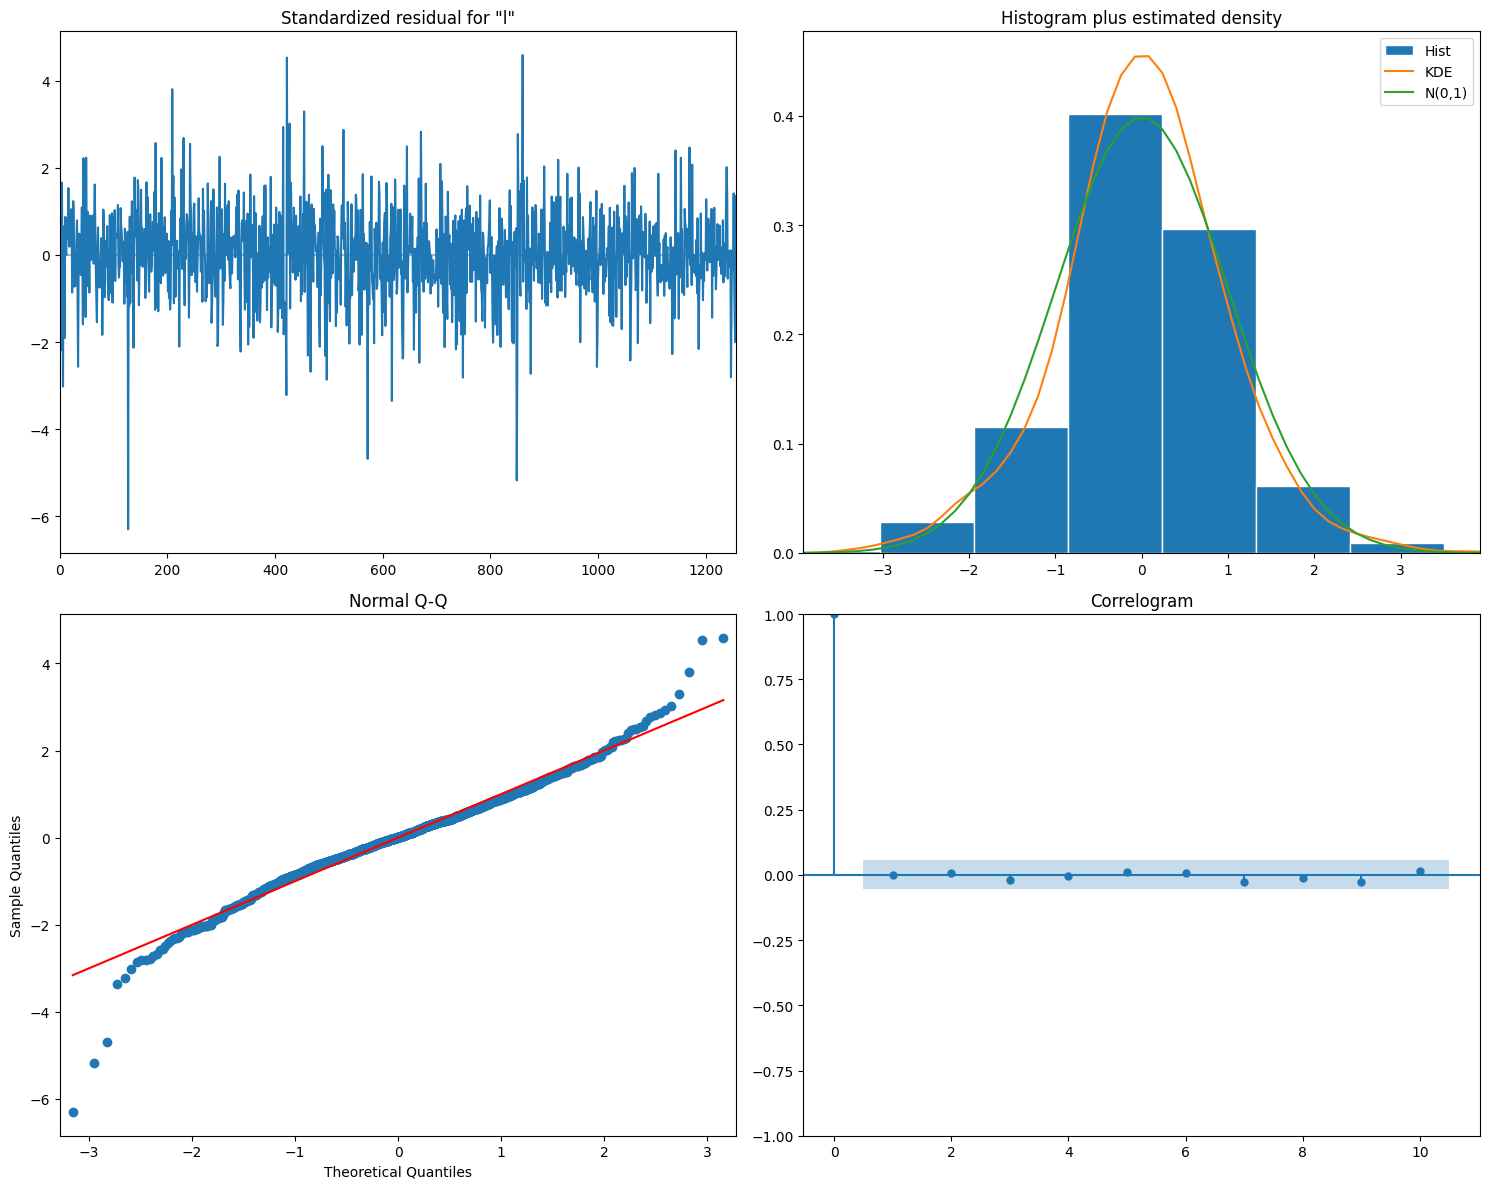


Gráfico 3: ACF dos Resíduos ao Quadrado (Efeitos ARCH)


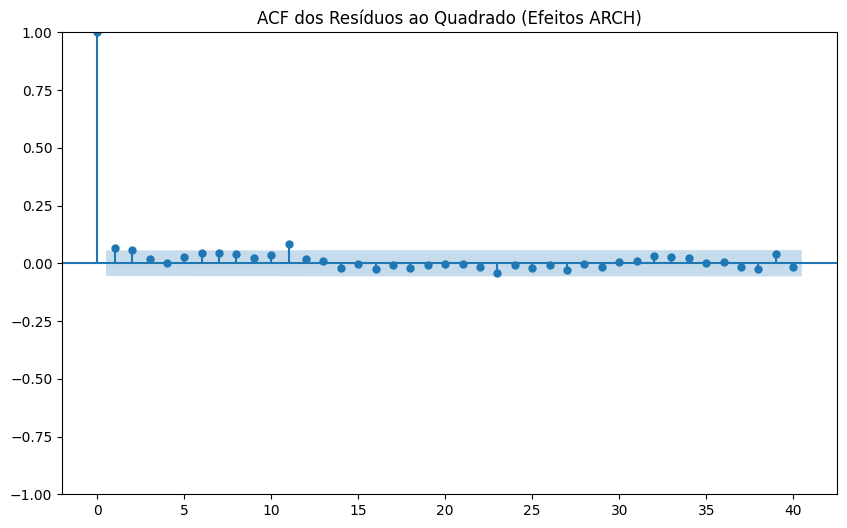


--- 3. Gráficos da análise de Cadeia de Markov ---

Gráfico 4: Heatmap da Matriz de Transição


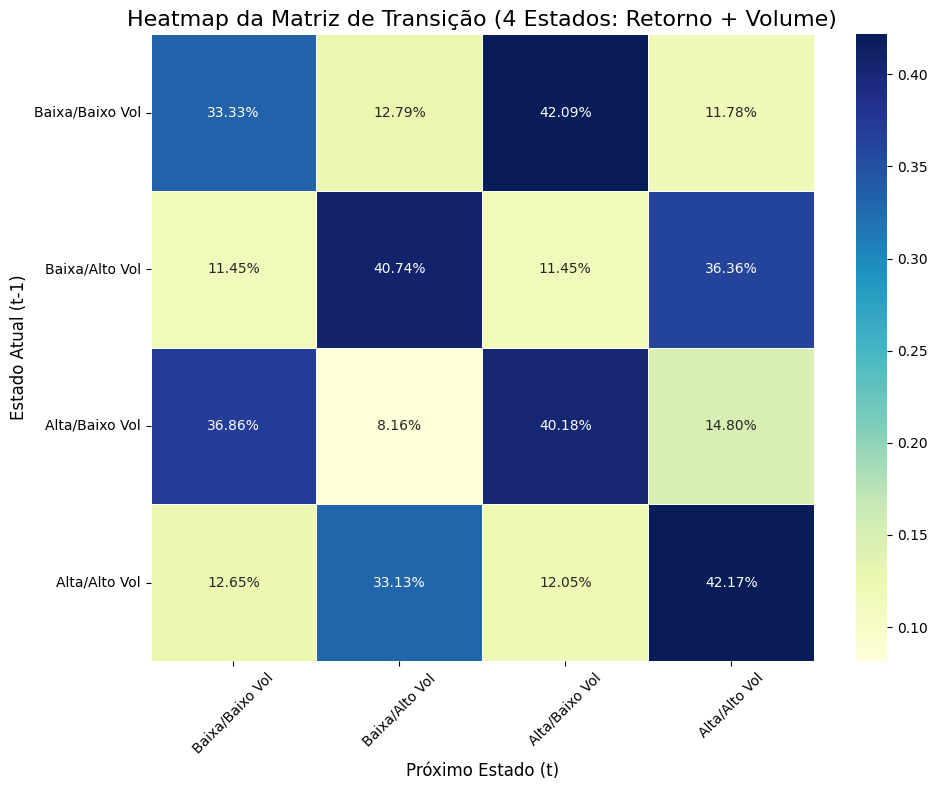


Gráfico 5: Distribuição Proporcional dos Estados


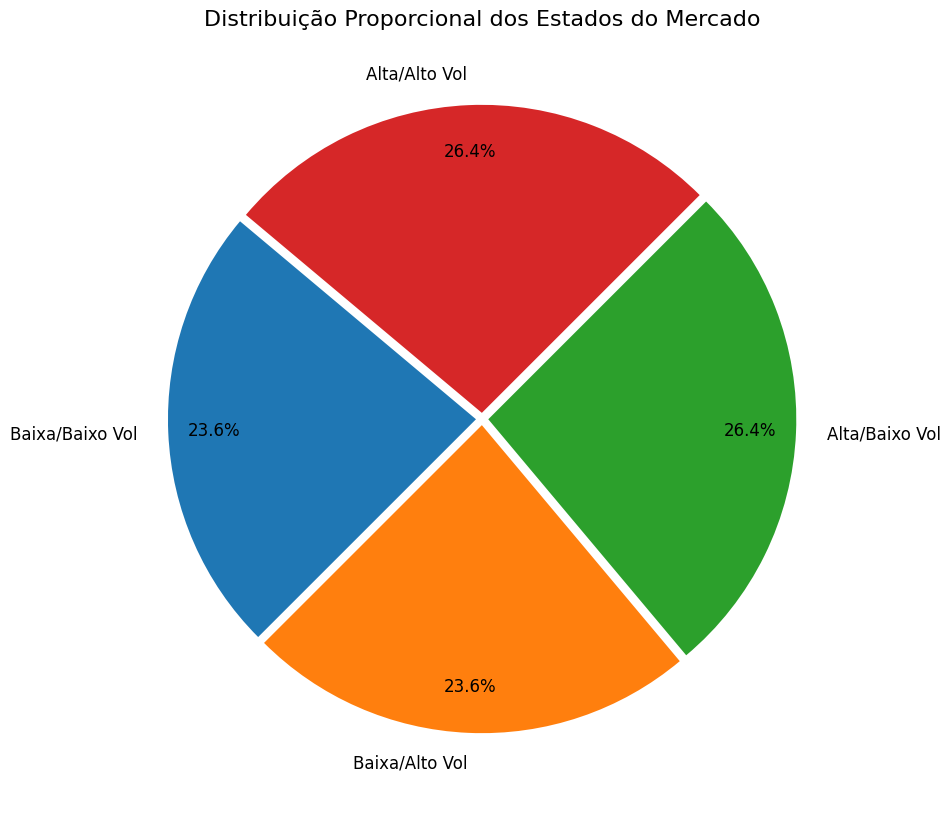

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# --- Bloco 1: Carregamento e Preparação dos Dados ---
print("--- 1. Carregando e preparando os dados ---")

# Carregar o arquivo CSV
df = pd.read_csv('all_stocks_5yr.csv')

# Isolar dados da AAL, processar datas e ordenar
df_aal = df[df['Name'] == 'AAL'].copy()
df_aal['date'] = pd.to_datetime(df_aal['date'])
df_aal.set_index('date', inplace=True)
df_aal.sort_index(inplace=True)
df_aal['log_return'] = np.log(df_aal['close'] / df_aal['close'].shift(1))
log_returns = df_aal['log_return'].dropna()
volume = df_aal['volume'].loc[log_returns.index]
print("Dados preparados.")


# --- Bloco 2: Gráficos da Análise ARIMA ---
print("\n--- 2. Gráficos da análise ARIMA ---")

# Gráfico 1: ACF e PACF para seleção de ordem
print("Gráfico 1: ACF e PACF dos Retornos Logarítmicos")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(log_returns, lags=40, ax=ax1, title='ACF dos Retornos Logarítmicos')
plot_pacf(log_returns, lags=40, ax=ax2, title='PACF dos Retornos Logarítmicos')
plt.tight_layout()
plt.show()


# Ajuste do modelo para obter resíduos
model = ARIMA(log_returns, order=(1, 0, 1))
results = model.fit()

# Gráfico 2: Diagnóstico completo do modelo ARIMA
print("\nGráfico 2: Diagnóstico do Modelo ARIMA")
fig = results.plot_diagnostics(figsize=(15, 12))
plt.tight_layout()
plt.show()


# Gráfico 3: ACF dos resíduos ao quadrado (para efeitos ARCH)
print("\nGráfico 3: ACF dos Resíduos ao Quadrado (Efeitos ARCH)")
squared_residuals = results.resid**2
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(squared_residuals, lags=40, ax=ax, title='ACF dos Resíduos ao Quadrado (Efeitos ARCH)')
plt.show()


# --- Bloco 3: Gráficos da Análise de Cadeia de Markov ---
print("\n--- 3. Gráficos da análise de Cadeia de Markov ---")

# Definição dos estados do modelo de 4 estados
volume_threshold = volume.median()
is_up_day = log_returns > 0
is_down_day = log_returns <= 0
is_high_volume = volume > volume_threshold
is_low_volume = volume <= volume_threshold
conditions = [
    is_down_day & is_low_volume,
    is_down_day & is_high_volume,
    is_up_day & is_low_volume,
    is_up_day & is_high_volume
]
state_values = [0, 1, 2, 3]
combined_states = pd.Series(np.select(conditions, state_values, default=np.nan), index=log_returns.index).dropna()
state_names = ['Baixa/Baixo Vol', 'Baixa/Alto Vol', 'Alta/Baixo Vol', 'Alta/Alto Vol']

# Cálculo da matriz de transição
transition_matrix = pd.crosstab(
    combined_states.shift(1),
    combined_states,
    normalize='index'
)
transition_matrix.index = state_names
transition_matrix.columns = state_names


# Gráfico 4: Heatmap da Matriz de Transição de 4 Estados
print("\nGráfico 4: Heatmap da Matriz de Transição")
plt.figure(figsize=(10, 8))
sns.heatmap(
    transition_matrix,
    annot=True,
    fmt=".2%",
    cmap="YlGnBu",
    linewidths=.5
)
plt.title('Heatmap da Matriz de Transição (4 Estados: Retorno + Volume)', fontsize=16)
plt.xlabel('Próximo Estado (t)', fontsize=12)
plt.ylabel('Estado Atual (t-1)', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Gráfico 5: Gráfico de Pizza da Distribuição dos Estados
print("\nGráfico 5: Distribuição Proporcional dos Estados")
state_distribution = combined_states.value_counts(normalize=True).sort_index()
state_distribution.index = state_names

plt.figure(figsize=(10, 10))
plt.pie(
    state_distribution,
    labels=state_distribution.index,
    autopct='%1.1f%%',
    startangle=140,
    explode=(0.02, 0.02, 0.02, 0.02),
    pctdistance=0.85,
    textprops={'fontsize': 12}
)
plt.title('Distribuição Proporcional dos Estados do Mercado', fontsize=16)
plt.show()

In [ ]:
### Código para Modelo VAR (Retorno + Volume)

import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR

# --- Bloco 1: Carregamento e Preparação dos Dados ---
print("--- 1. Carregando e preparando os dados para o modelo VAR ---")

# Carregar o conjunto de dados
df = pd.read_csv('all_stocks_5yr.csv')

# Filtrar para AAL e preparar os dados básicos
df_aal = df[df['Name'] == 'AAL'].copy()
df_aal['date'] = pd.to_datetime(df_aal['date'])
df_aal.set_index('date', inplace=True)
df_aal.sort_index(inplace=True)

# Criar a série de retorno logarítmico
df_aal['log_return'] = np.log(df_aal['close']).diff()

# Criar uma série para a variação do volume
# É importante transformar a série de volume para que ela também seja estacionária,
# assim como os retornos. Usar a variação do logaritmo do volume é uma prática comum.
df_aal['log_volume_growth'] = np.log(df_aal['volume']).diff()

# Criar o DataFrame final com as duas séries para o modelo
# Removemos os valores nulos (NaN) que surgem após a diferenciação
var_data = df_aal[['log_return', 'log_volume_growth']].dropna()

print("Dados preparados com as séries 'log_return' e 'log_volume_growth'.")
print(var_data.head())


# --- Bloco 2: Seleção da Ordem do Modelo (Número de Lags) ---
print("\n--- 2. Selecionando a ordem ótima de lags para o modelo VAR ---")
# Um passo crucial no VAR é decidir quantos períodos passados (lags) incluir.
# Usamos os critérios de informação (AIC, BIC) para nos ajudar a decidir.

model_for_selection = VAR(var_data)

# O método select_order testa várias ordens e nos mostra os resultados
# O ideal é escolher o lag que minimiza os valores de AIC ou BIC.
order_selection_results = model_for_selection.select_order(maxlags=10)
print(order_selection_results.summary())

# Vamos escolher o lag com base no critério AIC (marcado com *)
# Se o resultado for, por exemplo, 4, usaremos 4 lags no nosso modelo final.
# Para este exemplo, vamos fixar em 4, um valor comum nestas análises.
chosen_lag_order = 4
print(f"\nCom base nos critérios, um número razoável de lags a testar seria {chosen_lag_order}.")


# --- Bloco 3: Ajuste e Análise do Modelo VAR ---
print(f"\n--- 3. Ajustando o modelo VAR com {chosen_lag_order} lags ---")

# Usamos o mesmo objeto, mas agora ajustamos com a ordem escolhida
model_fitted = model_for_selection.fit(chosen_lag_order)

# Exibir o sumário completo dos resultados
print(model_fitted.summary())


# --- Bloco 4: Como Interpretar os Resultados ---
print("\n--- 4. Como Interpretar o Sumário do Modelo VAR ---")
print("""
O sumário acima mostra os resultados para DUAS equações separadas:
1. A equação para 'log_return' (na parte de cima).
2. A equação para 'log_volume_growth' (na parte de baixo).

Para cada equação, analise os coeficientes e seus p-valores (coluna P>|t|):

- Efeito do Volume no Retorno:
  Na primeira tabela ('Results for equation log_return'), procure os coeficientes para os lags do volume (ex: L1.log_volume_growth). Se o p-valor for baixo (< 0.05), significa que a variação do volume de ontem tem um efeito estatisticamente significativo no retorno de hoje.

- Efeito do Retorno no Volume:
  Na segunda tabela ('Results for equation log_volume_growth'), procure os coeficientes para os lags do retorno (ex: L1.log_return). Se o p-valor for baixo, significa que o retorno de ontem tem um efeito significativo na variação do volume de hoje (ex: uma grande queda ontem causa mais negociações hoje).

Este modelo captura o feedback dinâmico entre as duas variáveis.
""")

--- 1. Carregando e preparando os dados para o modelo VAR ---
Dados preparados com as séries 'log_return' e 'log_volume_growth'.
            log_return  log_volume_growth
date                                     
2013-02-11   -0.019857           0.054903
2013-02-12   -0.013227          -0.088958
2013-02-13    0.026963           0.233135
2013-02-14   -0.046780           1.133772
2013-02-15    0.035806          -0.712912

--- 2. Selecionando a ordem ótima de lags para o modelo VAR ---
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -9.326      -9.318   8.910e-05      -9.323
1       -9.423      -9.399   8.081e-05      -9.414
2       -9.470      -9.429   7.715e-05      -9.454
3       -9.494     -9.437*   7.529e-05      -9.473
4       -9.508      -9.434   7.425e-05      -9.480
5       -9.522      -9.431   7.325e-05     -9.488*
6      -9.526*      -9.419  7.291e-05*      -9.486
7 

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


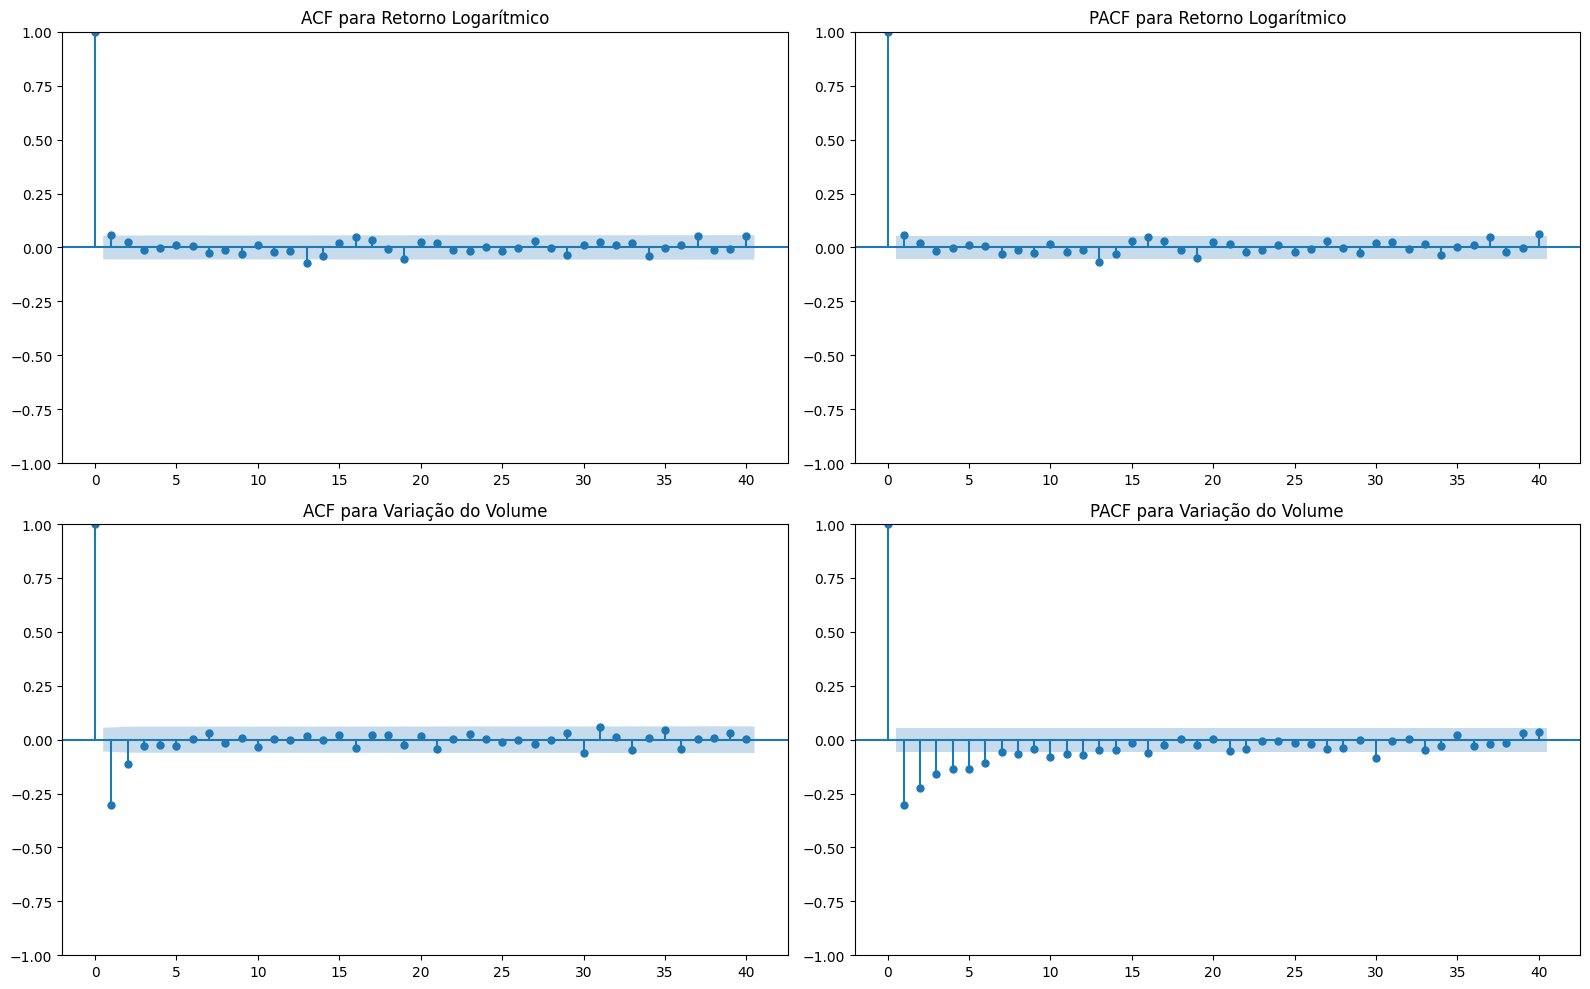

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- Bloco 1: Carregamento e Preparação dos Dados ---
# (O mesmo que fizemos para o modelo VAR)
df = pd.read_csv('all_stocks_5yr.csv')
df_aal = df[df['Name'] == 'AAL'].copy()
df_aal['date'] = pd.to_datetime(df_aal['date'])
df_aal.set_index('date', inplace=True)
df_aal.sort_index(inplace=True)

df_aal['log_return'] = np.log(df_aal['close']).diff()
df_aal['log_volume_growth'] = np.log(df_aal['volume']).diff()

var_data = df_aal[['log_return', 'log_volume_growth']].dropna()


# --- Bloco 2: Criação e Exibição dos Gráficos ---

# Criar uma figura com 4 subplots (2x2) para organizar os gráficos
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# --- Linha 1: Gráficos para o Retorno Logarítmico ---

# Plotar o ACF do Retorno
plot_acf(var_data['log_return'], ax=axes[0, 0], lags=40)
axes[0, 0].set_title('ACF para Retorno Logarítmico')

# Plotar o PACF do Retorno
plot_pacf(var_data['log_return'], ax=axes[0, 1], lags=40)
axes[0, 1].set_title('PACF para Retorno Logarítmico')


# --- Linha 2: Gráficos para a Variação do Volume ---

# Plotar o ACF da Variação do Volume
plot_acf(var_data['log_volume_growth'], ax=axes[1, 0], lags=40)
axes[1, 0].set_title('ACF para Variação do Volume')

# Plotar o PACF da Variação do Volume
plot_pacf(var_data['log_volume_growth'], ax=axes[1, 1], lags=40)
axes[1, 1].set_title('PACF para Variação do Volume')


# Ajustar o layout para evitar sobreposição e exibir
plt.tight_layout()
plt.show()

--- 1. Preparando os dados e a matriz de transição ---
Matriz de transição pronta.

--- 2. Executando a Simulação de Monte Carlo ---
100 caminhos futuros de 60 dias foram simulados.

--- 3. Plotando as simulações ---


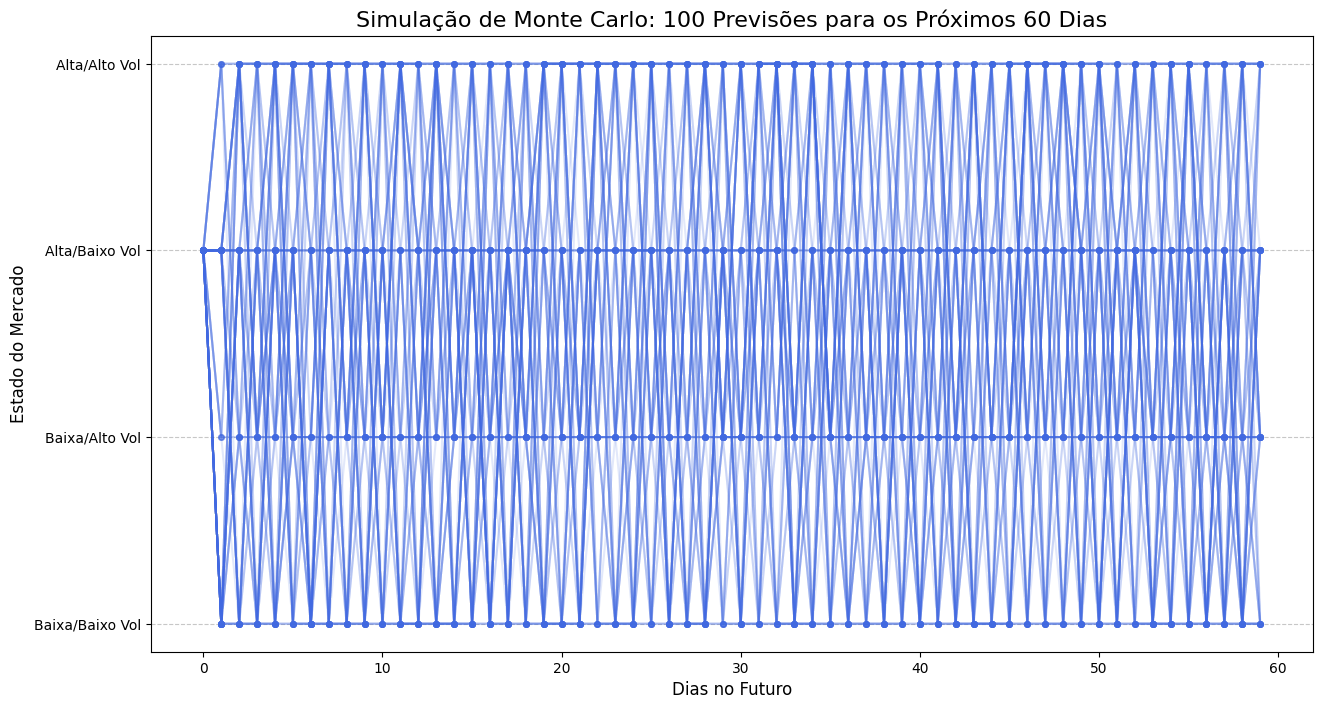

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Bloco 1: Preparação (código anterior para obter a matriz de transição) ---
print("--- 1. Preparando os dados e a matriz de transição ---")
df = pd.read_csv('all_stocks_5yr.csv')
df_aal = df[df['Name'] == 'AAL'].copy()
df_aal['date'] = pd.to_datetime(df_aal['date'])
df_aal.set_index('date', inplace=True)
df_aal.sort_index(inplace=True)
df_aal['log_return'] = np.log(df_aal['close'] / df_aal['close'].shift(1))
log_returns = df_aal['log_return'].dropna()
volume = df_aal['volume'].loc[log_returns.index]

volume_threshold = volume.median()
is_up_day = log_returns > 0
is_down_day = log_returns <= 0
is_high_volume = volume > volume_threshold
is_low_volume = volume <= volume_threshold
conditions = [
    is_down_day & is_low_volume,
    is_down_day & is_high_volume,
    is_up_day & is_low_volume,
    is_up_day & is_high_volume
]
state_values = [0, 1, 2, 3]
combined_states = pd.Series(np.select(conditions, state_values, default=np.nan), index=log_returns.index).dropna().astype(int)
state_names = ['Baixa/Baixo Vol', 'Baixa/Alto Vol', 'Alta/Baixo Vol', 'Alta/Alto Vol']

transition_matrix = pd.crosstab(
    combined_states.shift(1),
    combined_states,
    normalize='index'
).values # Usamos .values para ter a matriz como um array numpy

print("Matriz de transição pronta.")


# --- Bloco 2: Simulação de Monte Carlo ---
print("\n--- 2. Executando a Simulação de Monte Carlo ---")

# Parâmetros da Simulação
num_simulations = 100  # Número de futuros diferentes que vamos simular
forecast_horizon = 60 # Número de dias no futuro que vamos prever

# Ponto de partida: o último estado conhecido
start_state = combined_states.iloc[-1]

# Armazenar os resultados
all_paths = []

# Loop para cada simulação
for i in range(num_simulations):
    path = [start_state]
    current_state = start_state

    # Loop para cada dia na previsão
    for _ in range(forecast_horizon - 1):
        # Probabilidades de transição a partir do estado atual
        probs = transition_matrix[current_state]

        # "Sorteia" o próximo estado com base nas probabilidades
        next_state = np.random.choice([0, 1, 2, 3], p=probs)
        path.append(next_state)
        current_state = next_state

    all_paths.append(path)

print(f"{num_simulations} caminhos futuros de {forecast_horizon} dias foram simulados.")


# --- Bloco 3: Plotagem das Previsões Iterativas ---
print("\n--- 3. Plotando as simulações ---")

plt.figure(figsize=(15, 8))

# Plotar cada um dos caminhos simulados
for path in all_paths:
    plt.plot(path, marker='o', linestyle='-', markersize=4, alpha=0.15, color='royalblue')

plt.title(f'Simulação de Monte Carlo: {num_simulations} Previsões para os Próximos {forecast_horizon} Dias', fontsize=16)
plt.xlabel('Dias no Futuro', fontsize=12)
plt.ylabel('Estado do Mercado', fontsize=12)

# Ajustar os labels do eixo Y para os nomes dos estados
plt.yticks(ticks=[0, 1, 2, 3], labels=state_names)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

--- 1. Carregando e definindo os estados para todo o período ---
Estados definidos com sucesso.

--- 2. Dividindo os dados em treino (4 anos) e teste (1 ano) ---
Dados de treino: 1009 dias
Dados de teste: 249 dias

--- 3. Construindo a Matriz de Transição com dados de treino ---
Matriz de Transição de Treino:
[[0.297 0.159 0.39  0.154]
 [0.097 0.419 0.112 0.372]
 [0.341 0.09  0.386 0.184]
 [0.109 0.348 0.099 0.444]]

--- 4. Realizando a previsão dia a dia no conjunto de teste ---
Previsões concluídas.

--- 5. Analisando a performance do modelo ---

Probabilidade Média Atribuída ao Estado Correto: 30.73%
Interpretação: Um modelo aleatório atribuiria 25% de chance. Um valor maior que 25% indica que o modelo tem poder preditivo.


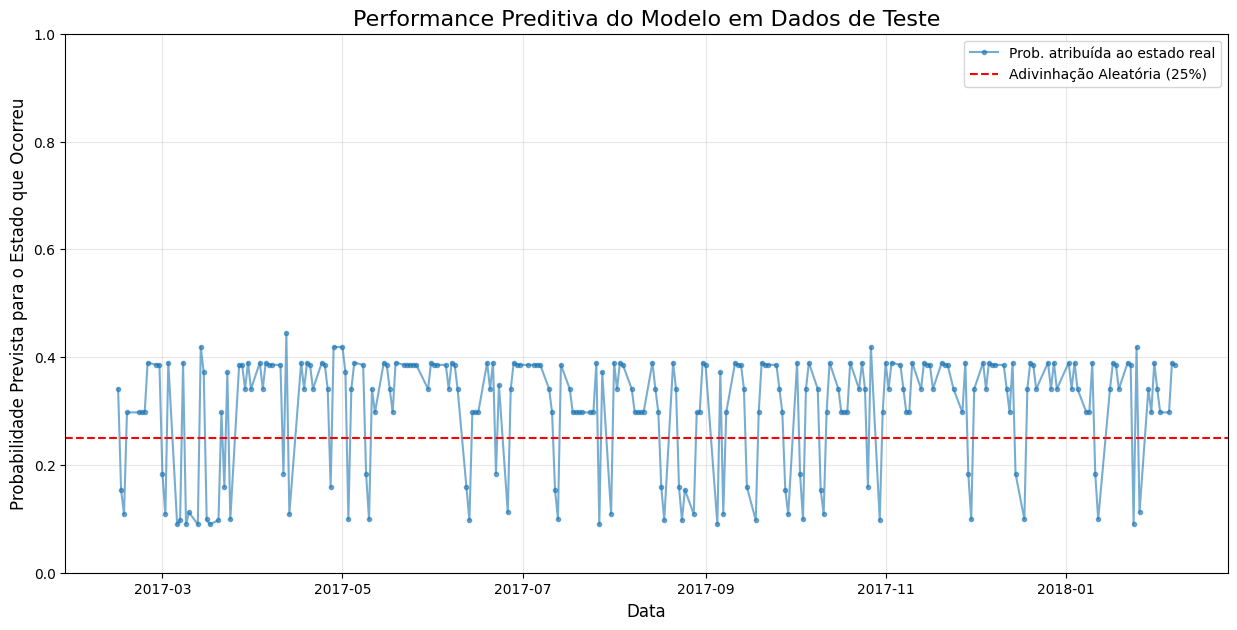

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Bloco 1: Preparação Completa dos Dados ---
print("--- 1. Carregando e definindo os estados para todo o período ---")
df = pd.read_csv('all_stocks_5yr.csv')
df_aal = df[df['Name'] == 'AAL'].copy()
df_aal['date'] = pd.to_datetime(df_aal['date'])
df_aal.set_index('date', inplace=True)
df_aal.sort_index(inplace=True)

df_aal['log_return'] = np.log(df_aal['close'] / df_aal['close'].shift(1))
log_returns = df_aal['log_return'].dropna()
volume = df_aal['volume'].loc[log_returns.index]

volume_threshold = volume.median()
conditions = [
    (log_returns <= 0) & (volume <= volume_threshold),
    (log_returns <= 0) & (volume > volume_threshold),
    (log_returns > 0) & (volume <= volume_threshold),
    (log_returns > 0) & (volume > volume_threshold)
]
state_values = [0, 1, 2, 3]
all_states = pd.Series(np.select(conditions, state_values, default=np.nan), index=log_returns.index).dropna().astype(int)

print("Estados definidos com sucesso.")

# --- Bloco 2: Divisão em Treino e Teste ---
print("\n--- 2. Dividindo os dados em treino (4 anos) e teste (1 ano) ---")
split_date = all_states.index[0] + pd.DateOffset(years=4)
train_states = all_states[all_states.index < split_date]
test_states = all_states[all_states.index >= split_date]
print(f"Dados de treino: {len(train_states)} dias")
print(f"Dados de teste: {len(test_states)} dias")

# --- Bloco 3: Construção do Modelo (APENAS COM DADOS DE TREINO) ---
print("\n--- 3. Construindo a Matriz de Transição com dados de treino ---")
train_transition_matrix = pd.crosstab(
    train_states.shift(1),
    train_states,
    normalize='index'
).values # .values para ter a matriz como array numpy

print("Matriz de Transição de Treino:")
print(np.round(train_transition_matrix, 3))


# --- Bloco 4: Realização da Previsão no Conjunto de Teste ---
print("\n--- 4. Realizando a previsão dia a dia no conjunto de teste ---")
predictions = []
actual_outcomes = []
prob_of_actual_outcome = []

# Loop a partir do segundo dia do conjunto de teste
for i in range(1, len(test_states)):
    previous_actual_state = test_states.iloc[i-1]
    current_actual_state = test_states.iloc[i]

    # Previsão: obter o vetor de probabilidades da matriz de treino
    predicted_probs = train_transition_matrix[previous_actual_state]

    # Armazenar a probabilidade que o modelo atribuiu ao que de fato aconteceu
    prob_of_actual_outcome.append(predicted_probs[current_actual_state])

    # Armazenar tudo para análise
    predictions.append(predicted_probs)
    actual_outcomes.append(current_actual_state)

print("Previsões concluídas.")


# --- Bloco 5: Análise dos Resultados da Previsão ---
print("\n--- 5. Analisando a performance do modelo ---")

# Métrica 1: Probabilidade Média Atribuída ao Resultado Correto
avg_prob = np.mean(prob_of_actual_outcome)
print(f"\nProbabilidade Média Atribuída ao Estado Correto: {avg_prob:.2%}")
print("Interpretação: Um modelo aleatório atribuiria 25% de chance. Um valor maior que 25% indica que o modelo tem poder preditivo.")

# Gráfico da Performance Preditiva
plt.figure(figsize=(15, 7))
plt.plot(test_states.index[1:], prob_of_actual_outcome,
         marker='.', linestyle='-', label='Prob. atribuída ao estado real', alpha=0.6)
plt.axhline(y=0.25, color='r', linestyle='--', label='Adivinhação Aleatória (25%)')
plt.title('Performance Preditiva do Modelo em Dados de Teste', fontsize=16)
plt.ylabel('Probabilidade Prevista para o Estado que Ocorreu', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.ylim(0, 1) # Probabilidades vão de 0 a 1
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()